# Utilities

In [1]:
import os
import keras
import mne
import numpy as np
import pandas as pd
import scipy.io
import tensorflow as tf
from mne.channels import make_standard_montage
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt

In [2]:
def annotations_from_eGUI(raw, egui):
    '''
    function to create mne annotations for a mne.Raw object from a time series 
    containing the state of the display
    '''
    
    codes = []
    starts = []
    current_state = None

    for i in range(len(egui)):
        if egui[i][0] != current_state:
            starts.append(i)
            current_state = egui[i][0]
            codes.append(str(egui[i][0]))

    starts.append(len(egui))
    codes = np.array(codes)
    sf = raw.info.get('sfreq')
    starts = np.array(starts) / sf
    durations = starts[1:] - starts[:-1]
    starts = starts[:-1]

    raw.set_annotations(mne.Annotations(onset=starts, duration=durations, description=codes))


def raw_from_mat(file):
    '''function to load data from a .mat file into a mne.Raw object'''
    mat = scipy.io.loadmat(os.path.join(data_dir, file))

    sampling_freq = mat["o"][0][0][2][0][0]
    n_samples = mat["o"][0][0][3][0][0]
    ch_names = [element[0][0] for element in mat["o"][0][0][6]]

    df = pd.DataFrame(mat["o"][0][0][5], columns=ch_names)
    df = df.drop(columns=["X5"])  # unsupported channel
    df = df.T
    ch_names.remove("X5")

    ch_types = ['eeg'] * 21
    info = mne.create_info(ch_names, ch_types=ch_types, sfreq=sampling_freq)
    raw = mne.io.RawArray(df.to_numpy(), info)

    montage = make_standard_montage("standard_prefixed")
    raw.set_montage(montage)

    raw.load_data().set_eeg_reference(ref_channels='average')
    annotations_from_eGUI(raw, mat["o"][0][0][4])
    return raw


def filter_raw(raw):
    return raw.load_data().filter(0.1, 30, method="fir", phase="zero-double")


def get_epochs(raw,event_id):
    '''function to extract mne epochs from a mne.Raw object'''
    metadata_tmin, metadata_tmax = -1, 1
    all_events, all_event_id = mne.events_from_annotations(raw,event_id=event_id,)
    metadata, events, event_id = mne.epochs.make_metadata(
        events=all_events,
        event_id=event_id,
        tmin=metadata_tmin,
        tmax=metadata_tmax,
        sfreq=raw.info["sfreq"],
    )
    print(raw.info["sfreq"])
    return mne.Epochs(raw, events, event_id, tmin=-1., tmax=1.,baseline=(-1,1))

# Data Loading and Preparation

We will create now several Datasets on which  we will test our methods.

 - `epochs_NoMT` will correspond to the data which is our baseline and where the subject is in a resting position whith no input on the screen. ( only take events "0")
 - `epochs_NOMT_only_code_2` will correspond to the data which comes from the same trails and session of the epochs_NoMT data, but here we select epochs where something is shown on the screen. (only take events "2")
 - `epochs_FREEFORM` will correspond to the data which comes from a diffrent session and here the subject can voluntarily  press buttons (either left or right)

In [3]:
# set up paths of data
data_dir = os.path.dirname("./data/")
data_files = os.listdir(data_dir)

In [4]:
#load data to raw objects
raw_NoMT = [raw_from_mat(file) for file in data_files if "NoMT" in file]
raw_FREEFORM = [raw_from_mat(file) for file in data_files if "FREEFORM" in file]

Creating RawArray with float64 data, n_channels=21, n_times=664400
    Range : 0 ... 664399 =      0.000 ...  3321.995 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Creating RawArray with float64 data, n_channels=21, n_times=664600
    Range : 0 ... 664599 =      0.000 ...  3322.995 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Creating RawArray with float64 data, n_channels=21, n_times=662400
    Range : 0 ... 662399 =      0.000 ...  3311.995 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Creating RawArray with float64 data, n_channels=21, n_times=667600
    Range : 0 ... 667599 =      0.000 ...  3337.995 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Creating RawArray with float64 d

In [5]:
#epoch data
epochs_NoMT = [get_epochs(file,{"0":1}) for file in raw_NoMT]
epochs_FREEFORM = [get_epochs(file,{'1': 2, '2': 3}) for file in raw_FREEFORM]
epochs_NOMT_only_code_2=[get_epochs(file,{"2":3}) for file in raw_NoMT]

Used Annotations descriptions: ['0']
200.0
Not setting metadata
966 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Used Annotations descriptions: ['0']
200.0
Not setting metadata
960 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Used Annotations descriptions: ['0']
200.0
Not setting metadata
963 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Used Annotations descriptions: ['0']
200.0
Not setting metadata
968 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Used Annotations descriptions: ['0']
200.0
Not setting metadata
968 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Used Annotations descriptions: ['0']
200.0
Not setting metadata
968 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Used Annotations descriptions: ['0

In [6]:
#put data in arrays
epochs_data_NOMT = [file.get_data() for file in epochs_NoMT]
epochs_data_FREEFORM = [file.get_data() for file in epochs_FREEFORM]
epochs_Data_NOMT_2 =[file.get_data() for file in epochs_NOMT_only_code_2]

X_NOMT = np.vstack(epochs_data_NOMT)
X_free = np.vstack(epochs_data_FREEFORM)
X_nomt_2 = np.vstack(epochs_Data_NOMT_2)

np.random.shuffle(X_NOMT)
np.random.shuffle(X_free)
np.random.shuffle(X_nomt_2)

print(X_NOMT.shape)
print(X_free.shape)
print(X_nomt_2.shape)

Using data from preloaded Raw for 966 events and 401 original time points ...
1 bad epochs dropped
Using data from preloaded Raw for 960 events and 401 original time points ...
1 bad epochs dropped
Using data from preloaded Raw for 963 events and 401 original time points ...
1 bad epochs dropped
Using data from preloaded Raw for 968 events and 401 original time points ...
1 bad epochs dropped
Using data from preloaded Raw for 968 events and 401 original time points ...
1 bad epochs dropped
Using data from preloaded Raw for 968 events and 401 original time points ...
1 bad epochs dropped
Using data from preloaded Raw for 967 events and 401 original time points ...
1 bad epochs dropped
Using data from preloaded Raw for 739 events and 401 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 688 events and 401 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 700 events and 401 original time points ...
0 bad epochs dropped
Using data

# Data Preprocessing

In [7]:
# split train data from nomt data
N = X_NOMT.shape[0]
X_nomt_train = X_NOMT[:5000]
X_nomt_test = X_NOMT[5000:]

In [8]:
print(X_nomt_train.shape)
print(X_nomt_test.shape)
print(X_free.shape)
print(X_nomt_2.shape)

(5000, 21, 401)
(1753, 21, 401)
(2127, 21, 401)
(1114, 21, 401)


In [9]:
# normalise data
norm_X_NOMT = layers.Normalization()
norm_X_free = layers.Normalization()
norm_X_nomt_2 = layers.Normalization()

norm_X_NOMT.adapt(X_NOMT.astype(float))
norm_X_free.adapt(X_free.astype(float))
norm_X_nomt_2.adapt(X_nomt_2.astype(float))

scaled_X_nomt_train=norm_X_NOMT(X_nomt_train)
scaled_X_nomt_test=norm_X_NOMT(X_nomt_test)
scaled_X_free=norm_X_free(X_free)
scaled_X_nomt_2=norm_X_nomt_2(X_nomt_2)

# Autoencoders

In [10]:
keras.backend.clear_session()

## small model

In [11]:
class Autoencoder_small(Model):
    def __init__(self):
        super(Autoencoder_small, self).__init__()
        self.encoder = tf.keras.Sequential([
            layers.Flatten(),
            layers.Dropout(0.5),
            layers.Dense(64, activation='gelu'),
        ])
        self.decoder = tf.keras.Sequential([
            layers.Dense(21 * 401, activation='linear'),
            layers.Dropout(0.5),
            layers.Reshape((21, 401))
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


autoencoder_small = Autoencoder_small()
autoencoder_small_scaled = Autoencoder_small()

# medium model

In [12]:
class Autoencoder_medium(Model):
    def __init__(self):
        super(Autoencoder_medium, self).__init__()
        self.encoder = tf.keras.Sequential([
            layers.Flatten(),
            layers.Dropout(0.5),
            layers.Dense(256, activation='gelu'),
            layers.Dropout(0.5),
            layers.Dense(128, activation='gelu'),
            layers.Dropout(0.5),
            layers.Dense(64, activation='gelu'),
        ])
        self.decoder = tf.keras.Sequential([
            layers.Dense(128, activation='gelu'),
            layers.Dropout(0.5),
            layers.Dense(256, activation='gelu'),
            layers.Dropout(0.5),
            layers.Dense(21 * 401, activation='linear'),
            layers.Reshape((21, 401))
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


autoencoder_medium = Autoencoder_medium()
autoencoder_medium_Scaled = Autoencoder_medium()

## large model

In [13]:
class Autoencoder_large(Model):
    def __init__(self):
        super(Autoencoder_large, self).__init__()
        self.encoder = tf.keras.Sequential([
            layers.Flatten(),
            layers.Dropout(0.5),
            layers.Dense(1024, activation='gelu'),
            layers.Dropout(0.5),
            layers.Dense(512, activation='gelu'),
            layers.Dropout(0.5),
            layers.Dense(128, activation='gelu'),
            layers.Dropout(0.5),
            layers.Dense(64, activation='gelu'),
        ])
        self.decoder = tf.keras.Sequential([
            layers.Dense(128, activation='gelu'),
            layers.Dropout(0.5),
            layers.Dense(512, activation='gelu'),
            layers.Dropout(0.5),
            layers.Dense(1024, activation='gelu'),
            layers.Dropout(0.5),
            layers.Dense(21 * 401, activation='linear'),
            layers.Reshape((21, 401))
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


autoencoder_large = Autoencoder_large()
autoencoder_large_Scaled = Autoencoder_large()

# Training Models

In [103]:
def train_model(ae, X_train, X_test, Y, lr, epochs, bs):
    '''function to train an autoencoder on the given data'''
    hist=ae.fit(X_train, X_train,
                epochs=epochs,
                batch_size=bs,
                shuffle=True,
                validation_data=(X_test, X_test),
                   verbose=0)
    
    plt.plot(hist.history["loss"])
    plt.plot(hist.history["val_loss"])
    plt.title('loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    return (hist.history["loss"],hist.history["val_loss"],lr.learning_rate.numpy(),epochs,bs)

def calc_accuracy(model,A, B, th):
    '''function to compute the accuracy of event classification by thresholding the reconstruction error'''
    _,_,a,b=calc_reconst(model,A,B,pr=False)
    first = [1 if i < th else 0 for i in a]
    last = [1 if i > th else 0 for i in b]
    last2=[0 if i > th else 1 for i in b]
    return sum(np.concatenate((first,last))) / len(np.concatenate((first,last))),np.concatenate((first,last2))

def calc_reconst(ae,A,B,pr=True):
    '''function to calculate the reconstruction error of an autoencoder on given data'''
    err = []
    err2 = []
    for i in A:
        # need to expand here because the flatten layer assumes that the first dimension is the number of samples
        i = np.expand_dims(i, axis=0)
        err.append((np.square(i - ae.call(i))).mean())

    for j in B:
        j = np.expand_dims(j, axis=0)
        err2.append((np.square(j - ae.call(j))).mean())
    if pr:
        print("Mean reconstruction errors : ")
        print(np.array(err).mean())
        print(np.array(err2).mean())
    return np.array(err).mean(),np.array(err2).mean(),err,err2

In [15]:
# optimiser set up
opt_e3 = keras.optimizers.Adam(learning_rate=1e-03)
opt_e4 = keras.optimizers.Adam(learning_rate=2e-05)
opt_e5 = keras.optimizers.Adam(learning_rate=1e-05)
opt_e6 = keras.optimizers.Adam(learning_rate=1e-06)

# hyperparameter set up
loss=losses.MeanSquaredError()
opti=[opt_e4,opt_e5]
epochs=[50,100,300,500]
bs=[128,512]

2e-05 128 50


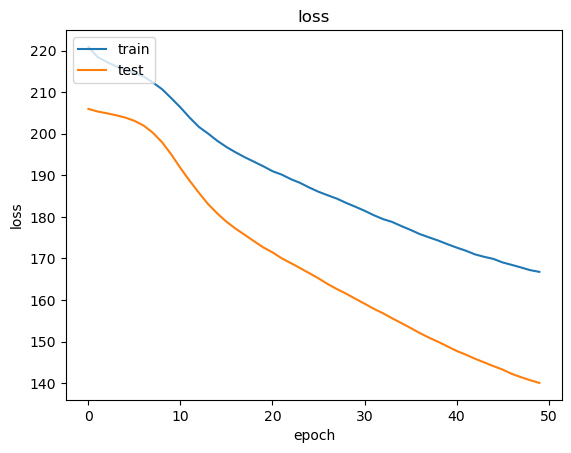

2e-05 128 100


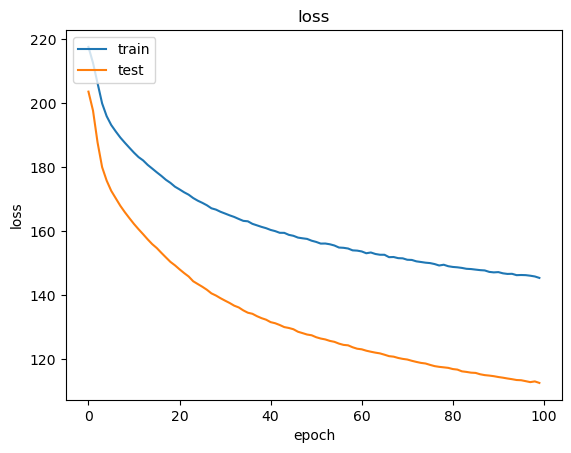

2e-05 128 300


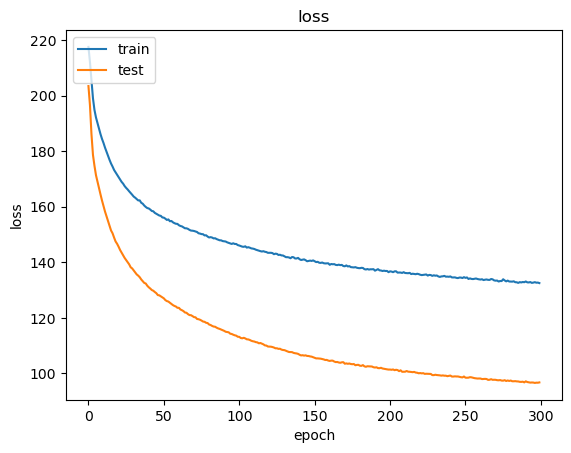

2e-05 128 500


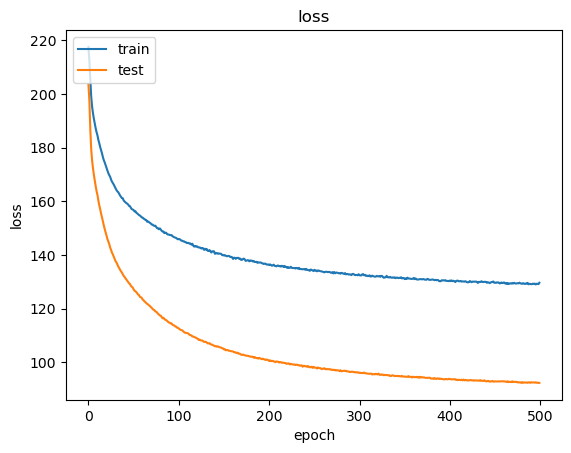

2e-05 512 50


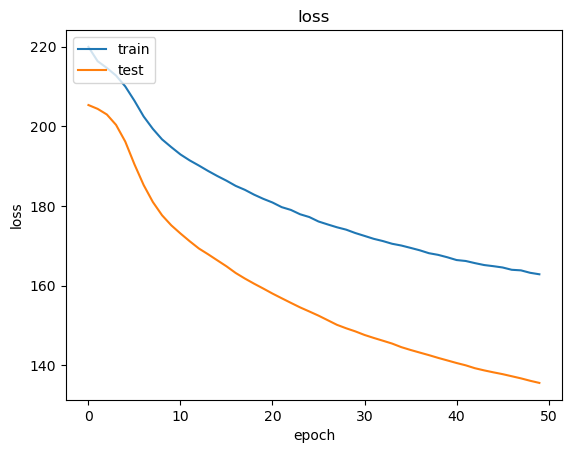

2e-05 512 100


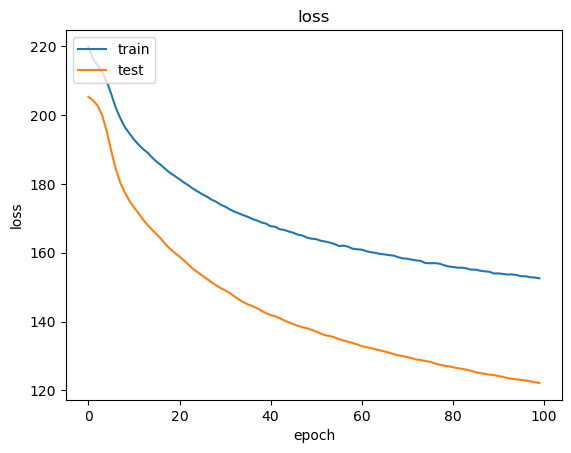

2e-05 512 300


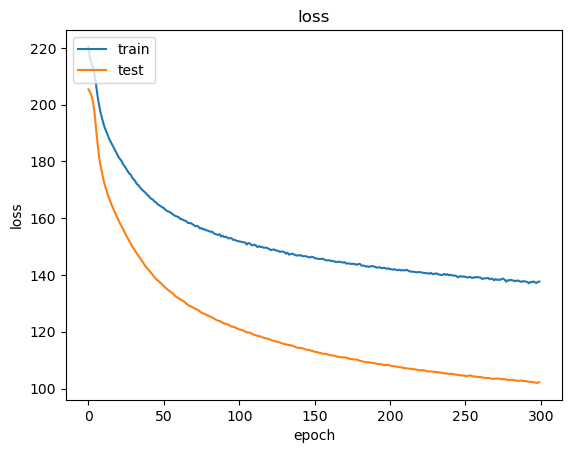

2e-05 512 500


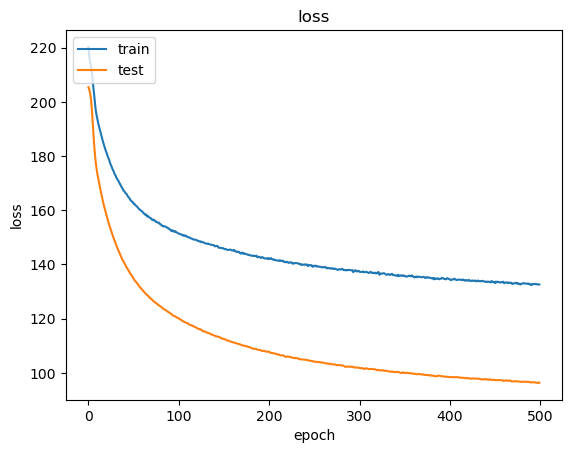

1e-05 128 50


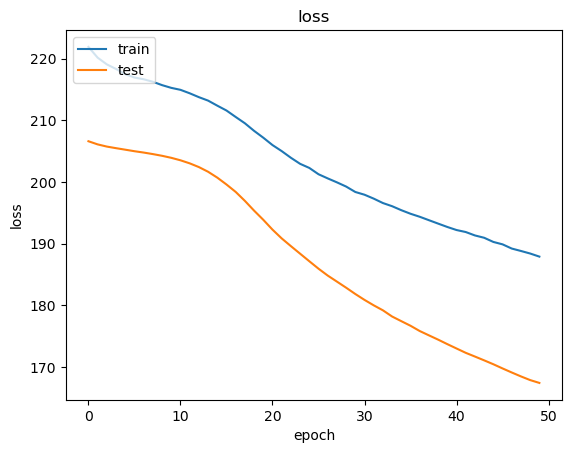

1e-05 128 100


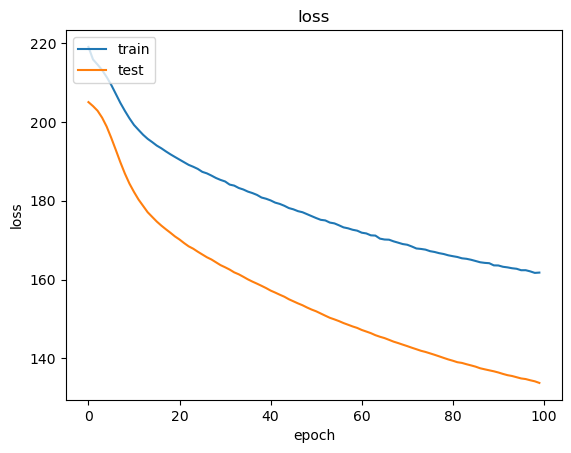

1e-05 128 300


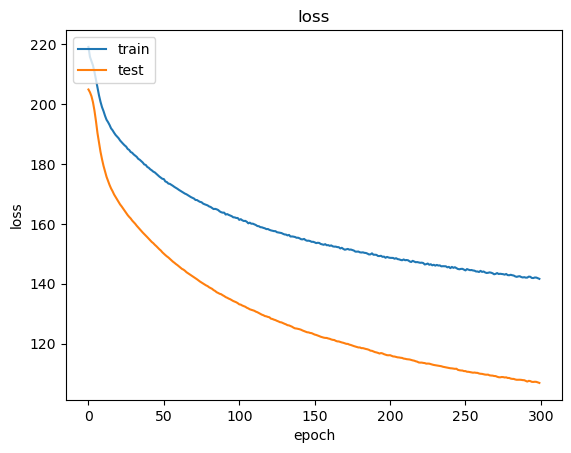

1e-05 128 500


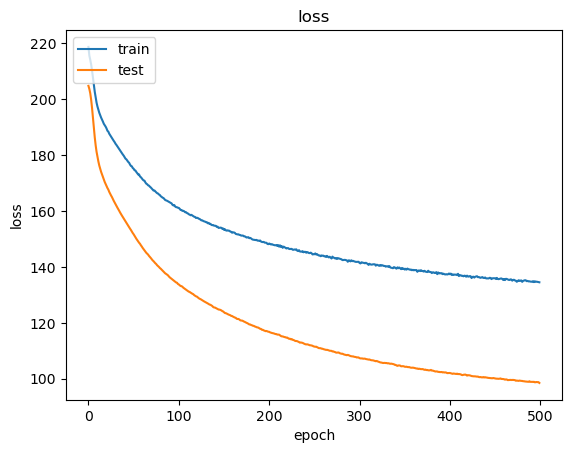

1e-05 512 50


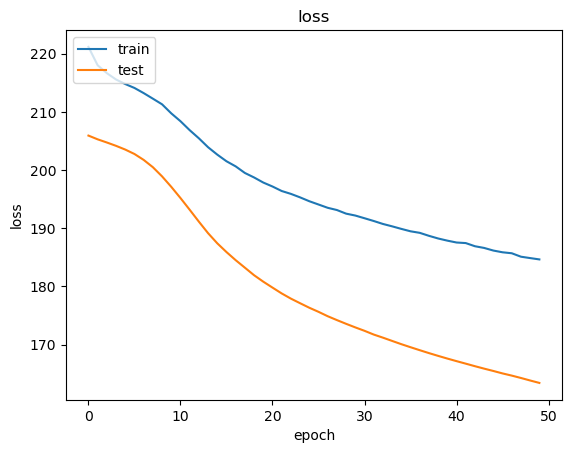

1e-05 512 100


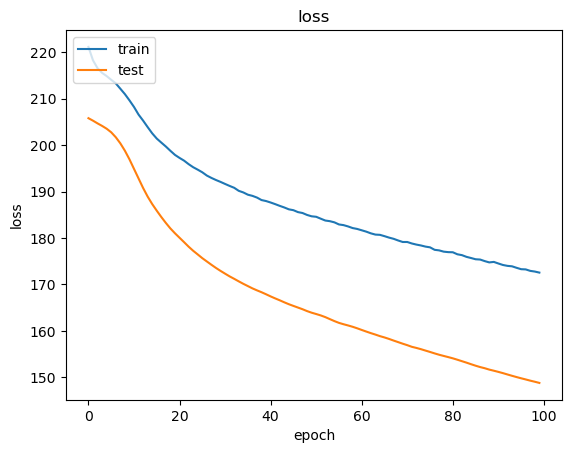

1e-05 512 300


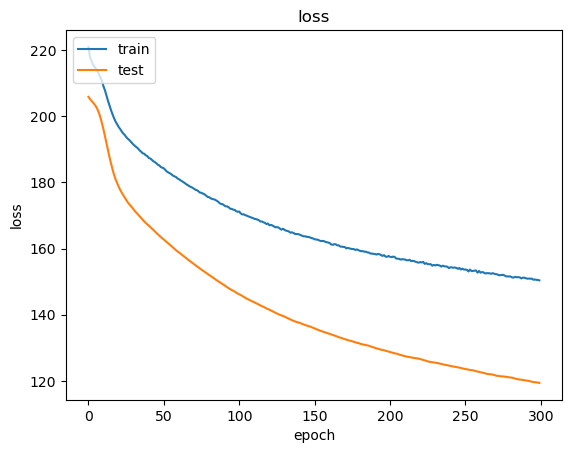

1e-05 512 500


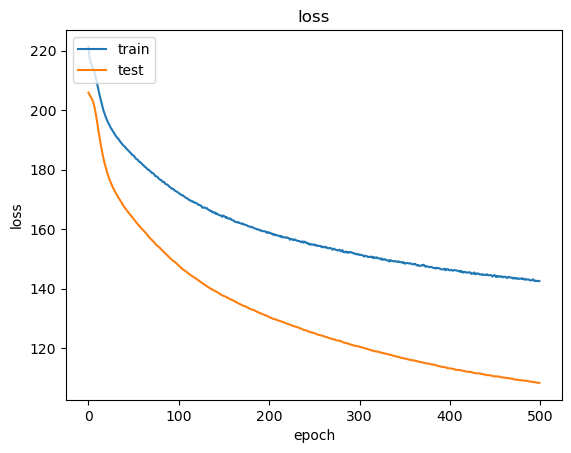

In [16]:
#find out which hyperparamters are reasonable
erg=[]
for opt in opti:
    for b in bs:
        for e in epochs:
            print(opt.learning_rate.numpy(),b,e)
            autoencoder_small = Autoencoder_small()
            autoencoder_small.compile(optimizer=opt, loss=loss)
            erg.append(train_model(autoencoder_small,X_nomt_train,X_nomt_test,_,opt,e,b))

## Not scaled data

### small model

In [78]:
autoencoder_small = Autoencoder_small()
autoencoder_small.compile(optimizer=opt_e4, loss=loss)
autoencoder_small.build((None, 21, 401))
autoencoder_small.summary()
autoencoder_small.fit(X_nomt_train, X_nomt_train,
                epochs=1000,
                batch_size=128,
                shuffle=True,
                validation_data=(X_nomt_test, X_nomt_test))


Model: "autoencoder_small_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_52 (Sequential)  (None, 64)                539008    
                                                                 
 sequential_53 (Sequential)  (None, 21, 401)           547365    
                                                                 
Total params: 1,086,373
Trainable params: 1,086,373
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
40/40 [==============================] - 1s 15ms/step - loss: 217.5629 - val_loss: 203.3932
Epoch 2/1000
40/40 [==============================] - 0s 10ms/step - loss: 212.1225 - val_loss: 196.9527
Epoch 3/1000
40/40 [==============================] - 0s 9ms/step - loss: 205.2405 - val_loss: 186.5616
Epoch 4/1000
40/40 [==============================] - 0s 9ms/step - loss: 199.0385 - val_loss: 179.1422
Epoch 5/1000
4

40/40 [==============================] - 0s 8ms/step - loss: 150.2370 - val_loss: 118.4755
Epoch 73/1000
40/40 [==============================] - 0s 9ms/step - loss: 149.7322 - val_loss: 118.3900
Epoch 74/1000
40/40 [==============================] - 0s 8ms/step - loss: 149.6675 - val_loss: 118.0109
Epoch 75/1000
40/40 [==============================] - 0s 9ms/step - loss: 149.5965 - val_loss: 117.8406
Epoch 76/1000
40/40 [==============================] - 0s 9ms/step - loss: 149.3213 - val_loss: 117.4627
Epoch 77/1000
40/40 [==============================] - 0s 9ms/step - loss: 149.1131 - val_loss: 117.2537
Epoch 78/1000
40/40 [==============================] - 0s 9ms/step - loss: 148.9009 - val_loss: 116.8075
Epoch 79/1000
40/40 [==============================] - 0s 9ms/step - loss: 148.6736 - val_loss: 116.5281
Epoch 80/1000
40/40 [==============================] - 0s 9ms/step - loss: 148.3725 - val_loss: 116.2187
Epoch 81/1000
40/40 [==============================] - 0s 9ms/step - 

40/40 [==============================] - 0s 9ms/step - loss: 139.6050 - val_loss: 104.8148
Epoch 150/1000
40/40 [==============================] - 0s 9ms/step - loss: 139.5370 - val_loss: 104.5147
Epoch 151/1000
40/40 [==============================] - 0s 9ms/step - loss: 139.2944 - val_loss: 104.5268
Epoch 152/1000
40/40 [==============================] - 0s 8ms/step - loss: 139.2404 - val_loss: 104.4071
Epoch 153/1000
40/40 [==============================] - 0s 9ms/step - loss: 139.4419 - val_loss: 104.2132
Epoch 154/1000
40/40 [==============================] - 0s 8ms/step - loss: 139.2733 - val_loss: 104.2797
Epoch 155/1000
40/40 [==============================] - 0s 8ms/step - loss: 139.1722 - val_loss: 104.1311
Epoch 156/1000
40/40 [==============================] - 0s 9ms/step - loss: 139.0743 - val_loss: 103.8392
Epoch 157/1000
40/40 [==============================] - 0s 9ms/step - loss: 138.8602 - val_loss: 103.8911
Epoch 158/1000
40/40 [==============================] - 0s 8m

40/40 [==============================] - 0s 9ms/step - loss: 134.9900 - val_loss: 99.4030
Epoch 227/1000
40/40 [==============================] - 0s 8ms/step - loss: 134.8390 - val_loss: 99.2346
Epoch 228/1000
40/40 [==============================] - 0s 9ms/step - loss: 134.7305 - val_loss: 99.1210
Epoch 229/1000
40/40 [==============================] - 0s 9ms/step - loss: 134.9050 - val_loss: 99.1706
Epoch 230/1000
40/40 [==============================] - 0s 8ms/step - loss: 135.1228 - val_loss: 98.9737
Epoch 231/1000
40/40 [==============================] - 0s 8ms/step - loss: 134.5232 - val_loss: 98.9012
Epoch 232/1000
40/40 [==============================] - 0s 8ms/step - loss: 134.3793 - val_loss: 99.0041
Epoch 233/1000
40/40 [==============================] - 0s 8ms/step - loss: 134.2770 - val_loss: 98.8536
Epoch 234/1000
40/40 [==============================] - 0s 9ms/step - loss: 135.1466 - val_loss: 98.8230
Epoch 235/1000
40/40 [==============================] - 0s 9ms/step - 

40/40 [==============================] - 0s 9ms/step - loss: 132.2453 - val_loss: 95.7815
Epoch 305/1000
40/40 [==============================] - 0s 9ms/step - loss: 132.2850 - val_loss: 96.1706
Epoch 306/1000
40/40 [==============================] - 0s 8ms/step - loss: 132.0572 - val_loss: 95.9032
Epoch 307/1000
40/40 [==============================] - 0s 8ms/step - loss: 132.2599 - val_loss: 95.9636
Epoch 308/1000
40/40 [==============================] - 0s 9ms/step - loss: 131.9950 - val_loss: 95.9213
Epoch 309/1000
40/40 [==============================] - 0s 9ms/step - loss: 131.8542 - val_loss: 95.8520
Epoch 310/1000
40/40 [==============================] - 0s 9ms/step - loss: 131.7665 - val_loss: 95.9556
Epoch 311/1000
40/40 [==============================] - 0s 9ms/step - loss: 132.0467 - val_loss: 95.8206
Epoch 312/1000
40/40 [==============================] - 0s 9ms/step - loss: 131.7537 - val_loss: 95.7621
Epoch 313/1000
40/40 [==============================] - 0s 9ms/step - 

40/40 [==============================] - 0s 8ms/step - loss: 130.7466 - val_loss: 94.3697
Epoch 383/1000
40/40 [==============================] - 0s 8ms/step - loss: 130.5206 - val_loss: 94.2506
Epoch 384/1000
40/40 [==============================] - 0s 9ms/step - loss: 130.5811 - val_loss: 94.1042
Epoch 385/1000
40/40 [==============================] - 0s 8ms/step - loss: 130.3819 - val_loss: 93.9610
Epoch 386/1000
40/40 [==============================] - 0s 9ms/step - loss: 130.3436 - val_loss: 94.1182
Epoch 387/1000
40/40 [==============================] - 0s 8ms/step - loss: 130.6504 - val_loss: 93.9827
Epoch 388/1000
40/40 [==============================] - 0s 8ms/step - loss: 130.2002 - val_loss: 94.0130
Epoch 389/1000
40/40 [==============================] - 0s 8ms/step - loss: 130.6355 - val_loss: 93.9176
Epoch 390/1000
40/40 [==============================] - 0s 9ms/step - loss: 130.1626 - val_loss: 94.0421
Epoch 391/1000
40/40 [==============================] - 0s 8ms/step - 

40/40 [==============================] - 0s 8ms/step - loss: 129.5559 - val_loss: 92.9230
Epoch 461/1000
40/40 [==============================] - 0s 8ms/step - loss: 129.2735 - val_loss: 92.9306
Epoch 462/1000
40/40 [==============================] - 0s 8ms/step - loss: 129.9825 - val_loss: 92.9292
Epoch 463/1000
40/40 [==============================] - 0s 8ms/step - loss: 129.4386 - val_loss: 92.7859
Epoch 464/1000
40/40 [==============================] - 0s 8ms/step - loss: 129.2458 - val_loss: 92.8821
Epoch 465/1000
40/40 [==============================] - 0s 8ms/step - loss: 129.5176 - val_loss: 92.7407
Epoch 466/1000
40/40 [==============================] - 0s 9ms/step - loss: 129.3522 - val_loss: 92.7411
Epoch 467/1000
40/40 [==============================] - 0s 8ms/step - loss: 129.4452 - val_loss: 92.8827
Epoch 468/1000
40/40 [==============================] - 0s 8ms/step - loss: 129.4319 - val_loss: 92.7677
Epoch 469/1000
40/40 [==============================] - 0s 8ms/step - 

40/40 [==============================] - 0s 9ms/step - loss: 128.7756 - val_loss: 92.1481
Epoch 539/1000
40/40 [==============================] - 0s 9ms/step - loss: 128.7449 - val_loss: 92.1944
Epoch 540/1000
40/40 [==============================] - 0s 9ms/step - loss: 128.7835 - val_loss: 92.1476
Epoch 541/1000
40/40 [==============================] - 0s 9ms/step - loss: 128.5538 - val_loss: 92.1843
Epoch 542/1000
40/40 [==============================] - 0s 9ms/step - loss: 128.7404 - val_loss: 92.2496
Epoch 543/1000
40/40 [==============================] - 0s 9ms/step - loss: 128.4682 - val_loss: 92.1908
Epoch 544/1000
40/40 [==============================] - 0s 9ms/step - loss: 128.5368 - val_loss: 92.1698
Epoch 545/1000
40/40 [==============================] - 0s 9ms/step - loss: 128.7315 - val_loss: 92.0060
Epoch 546/1000
40/40 [==============================] - 0s 9ms/step - loss: 128.8749 - val_loss: 92.0493
Epoch 547/1000
40/40 [==============================] - 0s 9ms/step - 

40/40 [==============================] - 0s 9ms/step - loss: 128.3586 - val_loss: 91.4429
Epoch 617/1000
40/40 [==============================] - 0s 9ms/step - loss: 128.4427 - val_loss: 91.5781
Epoch 618/1000
40/40 [==============================] - 0s 8ms/step - loss: 128.1783 - val_loss: 91.5716
Epoch 619/1000
40/40 [==============================] - 0s 9ms/step - loss: 128.4250 - val_loss: 91.4603
Epoch 620/1000
40/40 [==============================] - 0s 9ms/step - loss: 128.2619 - val_loss: 91.3832
Epoch 621/1000
40/40 [==============================] - 0s 8ms/step - loss: 128.4326 - val_loss: 91.4841
Epoch 622/1000
40/40 [==============================] - 0s 9ms/step - loss: 128.2370 - val_loss: 91.6195
Epoch 623/1000
40/40 [==============================] - 0s 8ms/step - loss: 128.0504 - val_loss: 91.6815
Epoch 624/1000
40/40 [==============================] - 0s 8ms/step - loss: 128.0234 - val_loss: 91.6056
Epoch 625/1000
40/40 [==============================] - 0s 8ms/step - 

40/40 [==============================] - 0s 8ms/step - loss: 127.6340 - val_loss: 91.1406
Epoch 695/1000
40/40 [==============================] - 0s 8ms/step - loss: 127.9559 - val_loss: 91.1054
Epoch 696/1000
40/40 [==============================] - 0s 9ms/step - loss: 128.1565 - val_loss: 91.2377
Epoch 697/1000
40/40 [==============================] - 0s 9ms/step - loss: 127.9011 - val_loss: 91.1255
Epoch 698/1000
40/40 [==============================] - 0s 9ms/step - loss: 127.5755 - val_loss: 91.2188
Epoch 699/1000
40/40 [==============================] - 0s 9ms/step - loss: 128.0822 - val_loss: 91.2299
Epoch 700/1000
40/40 [==============================] - 0s 8ms/step - loss: 127.6501 - val_loss: 91.3128
Epoch 701/1000
40/40 [==============================] - 0s 9ms/step - loss: 128.2894 - val_loss: 91.1199
Epoch 702/1000
40/40 [==============================] - 0s 9ms/step - loss: 127.7330 - val_loss: 91.2096
Epoch 703/1000
40/40 [==============================] - 0s 8ms/step - 

40/40 [==============================] - 0s 9ms/step - loss: 127.7061 - val_loss: 90.8683
Epoch 773/1000
40/40 [==============================] - 0s 8ms/step - loss: 127.7027 - val_loss: 90.9698
Epoch 774/1000
40/40 [==============================] - 0s 8ms/step - loss: 127.8068 - val_loss: 90.8893
Epoch 775/1000
40/40 [==============================] - 0s 8ms/step - loss: 127.7508 - val_loss: 90.7587
Epoch 776/1000
40/40 [==============================] - 0s 9ms/step - loss: 127.4904 - val_loss: 90.7185
Epoch 777/1000
40/40 [==============================] - 0s 9ms/step - loss: 127.7266 - val_loss: 90.8539
Epoch 778/1000
40/40 [==============================] - 0s 9ms/step - loss: 127.7342 - val_loss: 90.8288
Epoch 779/1000
40/40 [==============================] - 0s 9ms/step - loss: 127.7999 - val_loss: 90.8120
Epoch 780/1000
40/40 [==============================] - 0s 9ms/step - loss: 127.5508 - val_loss: 90.8714
Epoch 781/1000
40/40 [==============================] - 0s 8ms/step - 

40/40 [==============================] - 0s 9ms/step - loss: 127.4506 - val_loss: 90.7032
Epoch 851/1000
40/40 [==============================] - 0s 9ms/step - loss: 127.5045 - val_loss: 90.6880
Epoch 852/1000
40/40 [==============================] - 0s 9ms/step - loss: 127.4068 - val_loss: 90.5290
Epoch 853/1000
40/40 [==============================] - 0s 9ms/step - loss: 127.5509 - val_loss: 90.7304
Epoch 854/1000
40/40 [==============================] - 0s 8ms/step - loss: 127.4774 - val_loss: 90.8450
Epoch 855/1000
40/40 [==============================] - 0s 9ms/step - loss: 127.6289 - val_loss: 90.7261
Epoch 856/1000
40/40 [==============================] - 0s 9ms/step - loss: 127.2227 - val_loss: 90.6733
Epoch 857/1000
40/40 [==============================] - 0s 9ms/step - loss: 127.8123 - val_loss: 90.6881
Epoch 858/1000
40/40 [==============================] - 0s 9ms/step - loss: 127.5311 - val_loss: 90.5894
Epoch 859/1000
40/40 [==============================] - 0s 9ms/step - 

40/40 [==============================] - 0s 9ms/step - loss: 127.5747 - val_loss: 90.6408
Epoch 929/1000
40/40 [==============================] - 0s 9ms/step - loss: 127.1100 - val_loss: 90.6973
Epoch 930/1000
40/40 [==============================] - 0s 9ms/step - loss: 127.4151 - val_loss: 90.5075
Epoch 931/1000
40/40 [==============================] - 0s 8ms/step - loss: 127.4979 - val_loss: 90.5442
Epoch 932/1000
40/40 [==============================] - 0s 9ms/step - loss: 127.3023 - val_loss: 90.6588
Epoch 933/1000
40/40 [==============================] - 0s 8ms/step - loss: 127.2330 - val_loss: 90.5748
Epoch 934/1000
40/40 [==============================] - 0s 8ms/step - loss: 127.3980 - val_loss: 90.5883
Epoch 935/1000
40/40 [==============================] - 0s 9ms/step - loss: 126.9521 - val_loss: 90.5941
Epoch 936/1000
40/40 [==============================] - 0s 8ms/step - loss: 127.3698 - val_loss: 90.6742
Epoch 937/1000
40/40 [==============================] - 0s 9ms/step - 

### medium

In [79]:
autoencoder_medium =Autoencoder_medium()
autoencoder_medium.compile(optimizer=opt_e4, loss=loss)
autoencoder_medium.build((None, 21, 401))
print(autoencoder_medium.layers[0].summary())
autoencoder_medium.summary()
autoencoder_medium.fit(X_nomt_train, X_nomt_train,
                epochs=1000,
                batch_size=128,
                shuffle=True,
                validation_data=(X_nomt_test, X_nomt_test))

Model: "sequential_54"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_27 (Flatten)        (None, 8421)              0         
                                                                 
 dropout_78 (Dropout)        (None, 8421)              0         
                                                                 
 dense_84 (Dense)            (None, 256)               2156032   
                                                                 
 dropout_79 (Dropout)        (None, 256)               0         
                                                                 
 dense_85 (Dense)            (None, 128)               32896     
                                                                 
 dropout_80 (Dropout)        (None, 128)               0         
                                                                 
 dense_86 (Dense)            (None, 64)              

Epoch 59/1000
40/40 [==============================] - 1s 13ms/step - loss: 192.8716 - val_loss: 189.9288
Epoch 60/1000
40/40 [==============================] - 1s 13ms/step - loss: 192.8143 - val_loss: 189.5426
Epoch 61/1000
40/40 [==============================] - 1s 14ms/step - loss: 192.5595 - val_loss: 188.7886
Epoch 62/1000
40/40 [==============================] - 1s 14ms/step - loss: 192.7106 - val_loss: 188.7941
Epoch 63/1000
40/40 [==============================] - 1s 14ms/step - loss: 192.4653 - val_loss: 189.4055
Epoch 64/1000
40/40 [==============================] - 1s 14ms/step - loss: 192.6499 - val_loss: 189.0547
Epoch 65/1000
40/40 [==============================] - 1s 13ms/step - loss: 192.1578 - val_loss: 189.6292
Epoch 66/1000
40/40 [==============================] - 1s 14ms/step - loss: 192.1473 - val_loss: 189.2736
Epoch 67/1000
40/40 [==============================] - 1s 13ms/step - loss: 192.8129 - val_loss: 188.7403
Epoch 68/1000
40/40 [=========================

Epoch 136/1000
40/40 [==============================] - 1s 14ms/step - loss: 177.0350 - val_loss: 171.0690
Epoch 137/1000
40/40 [==============================] - 1s 13ms/step - loss: 176.3342 - val_loss: 170.8578
Epoch 138/1000
40/40 [==============================] - 1s 13ms/step - loss: 177.6470 - val_loss: 170.7940
Epoch 139/1000
40/40 [==============================] - 1s 13ms/step - loss: 176.5024 - val_loss: 170.7937
Epoch 140/1000
40/40 [==============================] - 1s 14ms/step - loss: 176.3670 - val_loss: 170.1251
Epoch 141/1000
40/40 [==============================] - 1s 13ms/step - loss: 177.5769 - val_loss: 169.9545
Epoch 142/1000
40/40 [==============================] - 1s 13ms/step - loss: 176.5620 - val_loss: 170.3235
Epoch 143/1000
40/40 [==============================] - 1s 14ms/step - loss: 176.4550 - val_loss: 170.1460
Epoch 144/1000
40/40 [==============================] - 1s 14ms/step - loss: 177.2335 - val_loss: 170.2231
Epoch 145/1000
40/40 [===============

40/40 [==============================] - 1s 13ms/step - loss: 168.9037 - val_loss: 162.9494
Epoch 213/1000
40/40 [==============================] - 1s 13ms/step - loss: 170.1543 - val_loss: 162.8185
Epoch 214/1000
40/40 [==============================] - 1s 13ms/step - loss: 168.3291 - val_loss: 162.9456
Epoch 215/1000
40/40 [==============================] - 1s 13ms/step - loss: 169.6097 - val_loss: 162.8976
Epoch 216/1000
40/40 [==============================] - 1s 14ms/step - loss: 168.9505 - val_loss: 162.9599
Epoch 217/1000
40/40 [==============================] - 1s 13ms/step - loss: 168.5506 - val_loss: 162.7954
Epoch 218/1000
40/40 [==============================] - 1s 13ms/step - loss: 168.2181 - val_loss: 162.2523
Epoch 219/1000
40/40 [==============================] - 1s 13ms/step - loss: 167.6295 - val_loss: 162.1342
Epoch 220/1000
40/40 [==============================] - 1s 13ms/step - loss: 168.4698 - val_loss: 161.6323
Epoch 221/1000
40/40 [==============================

40/40 [==============================] - 1s 14ms/step - loss: 163.5748 - val_loss: 155.6635
Epoch 289/1000
40/40 [==============================] - 1s 14ms/step - loss: 164.6362 - val_loss: 155.9879
Epoch 290/1000
40/40 [==============================] - 1s 14ms/step - loss: 163.3980 - val_loss: 155.8681
Epoch 291/1000
40/40 [==============================] - 1s 14ms/step - loss: 162.6584 - val_loss: 155.7702
Epoch 292/1000
40/40 [==============================] - 1s 13ms/step - loss: 163.4101 - val_loss: 155.5534
Epoch 293/1000
40/40 [==============================] - 1s 14ms/step - loss: 163.3900 - val_loss: 155.5769
Epoch 294/1000
40/40 [==============================] - 1s 14ms/step - loss: 161.9597 - val_loss: 155.2667
Epoch 295/1000
40/40 [==============================] - 1s 14ms/step - loss: 163.5173 - val_loss: 155.8564
Epoch 296/1000
40/40 [==============================] - 1s 14ms/step - loss: 163.0846 - val_loss: 155.8902
Epoch 297/1000
40/40 [==============================

40/40 [==============================] - 1s 17ms/step - loss: 158.7548 - val_loss: 150.7741
Epoch 365/1000
40/40 [==============================] - 1s 18ms/step - loss: 158.3130 - val_loss: 150.5309
Epoch 366/1000
40/40 [==============================] - 1s 16ms/step - loss: 158.4679 - val_loss: 150.6453
Epoch 367/1000
40/40 [==============================] - 1s 16ms/step - loss: 159.0190 - val_loss: 150.6594
Epoch 368/1000
40/40 [==============================] - 1s 17ms/step - loss: 158.3118 - val_loss: 150.7451
Epoch 369/1000
40/40 [==============================] - 1s 17ms/step - loss: 158.5099 - val_loss: 150.7762
Epoch 370/1000
40/40 [==============================] - 1s 15ms/step - loss: 159.4379 - val_loss: 150.4358
Epoch 371/1000
40/40 [==============================] - 1s 16ms/step - loss: 158.9636 - val_loss: 150.1410
Epoch 372/1000
40/40 [==============================] - 1s 15ms/step - loss: 157.2642 - val_loss: 150.4963
Epoch 373/1000
40/40 [==============================

40/40 [==============================] - 1s 13ms/step - loss: 155.9183 - val_loss: 147.4729
Epoch 441/1000
40/40 [==============================] - 1s 14ms/step - loss: 155.2049 - val_loss: 147.1603
Epoch 442/1000
40/40 [==============================] - 1s 14ms/step - loss: 154.1966 - val_loss: 146.7233
Epoch 443/1000
40/40 [==============================] - 1s 14ms/step - loss: 155.5876 - val_loss: 146.8247
Epoch 444/1000
40/40 [==============================] - 1s 13ms/step - loss: 153.5957 - val_loss: 146.7702
Epoch 445/1000
40/40 [==============================] - 1s 13ms/step - loss: 155.4359 - val_loss: 146.9282
Epoch 446/1000
40/40 [==============================] - 1s 14ms/step - loss: 154.2755 - val_loss: 147.0830
Epoch 447/1000
40/40 [==============================] - 1s 13ms/step - loss: 155.2392 - val_loss: 147.1813
Epoch 448/1000
40/40 [==============================] - 1s 14ms/step - loss: 155.2066 - val_loss: 146.8188
Epoch 449/1000
40/40 [==============================

40/40 [==============================] - 1s 13ms/step - loss: 152.6500 - val_loss: 144.1852
Epoch 517/1000
40/40 [==============================] - 1s 13ms/step - loss: 151.4362 - val_loss: 143.8390
Epoch 518/1000
40/40 [==============================] - 1s 13ms/step - loss: 151.3064 - val_loss: 142.9145
Epoch 519/1000
40/40 [==============================] - 1s 14ms/step - loss: 151.3601 - val_loss: 143.2825
Epoch 520/1000
40/40 [==============================] - 1s 13ms/step - loss: 151.2136 - val_loss: 143.7300
Epoch 521/1000
40/40 [==============================] - 1s 14ms/step - loss: 151.8284 - val_loss: 143.6100
Epoch 522/1000
40/40 [==============================] - 1s 14ms/step - loss: 151.0407 - val_loss: 143.7388
Epoch 523/1000
40/40 [==============================] - 1s 14ms/step - loss: 151.6052 - val_loss: 143.7891
Epoch 524/1000
40/40 [==============================] - 1s 15ms/step - loss: 150.7804 - val_loss: 143.6227
Epoch 525/1000
40/40 [==============================

40/40 [==============================] - 1s 16ms/step - loss: 147.0651 - val_loss: 140.1051
Epoch 593/1000
40/40 [==============================] - 1s 15ms/step - loss: 147.1324 - val_loss: 139.7431
Epoch 594/1000
40/40 [==============================] - 1s 14ms/step - loss: 148.0687 - val_loss: 139.7521
Epoch 595/1000
40/40 [==============================] - 1s 14ms/step - loss: 146.0569 - val_loss: 139.5298
Epoch 596/1000
40/40 [==============================] - 1s 14ms/step - loss: 148.2108 - val_loss: 139.4864
Epoch 597/1000
40/40 [==============================] - 1s 14ms/step - loss: 147.0352 - val_loss: 139.1482
Epoch 598/1000
40/40 [==============================] - 1s 15ms/step - loss: 147.4703 - val_loss: 139.1998
Epoch 599/1000
40/40 [==============================] - 1s 14ms/step - loss: 148.1660 - val_loss: 139.5606
Epoch 600/1000
40/40 [==============================] - 1s 14ms/step - loss: 145.4676 - val_loss: 139.5512
Epoch 601/1000
40/40 [==============================

40/40 [==============================] - 1s 15ms/step - loss: 144.0465 - val_loss: 137.5775
Epoch 669/1000
40/40 [==============================] - 1s 14ms/step - loss: 146.5130 - val_loss: 137.5998
Epoch 670/1000
40/40 [==============================] - 1s 13ms/step - loss: 147.9996 - val_loss: 137.5025
Epoch 671/1000
40/40 [==============================] - 1s 14ms/step - loss: 145.2685 - val_loss: 136.9931
Epoch 672/1000
40/40 [==============================] - 1s 14ms/step - loss: 144.6219 - val_loss: 136.5737
Epoch 673/1000
40/40 [==============================] - 1s 14ms/step - loss: 148.3768 - val_loss: 136.9252
Epoch 674/1000
40/40 [==============================] - 1s 14ms/step - loss: 145.1907 - val_loss: 136.9187
Epoch 675/1000
40/40 [==============================] - 1s 14ms/step - loss: 146.6942 - val_loss: 137.0114
Epoch 676/1000
40/40 [==============================] - 1s 14ms/step - loss: 144.6685 - val_loss: 136.6309
Epoch 677/1000
40/40 [==============================

40/40 [==============================] - 1s 14ms/step - loss: 143.1241 - val_loss: 135.1422
Epoch 745/1000
40/40 [==============================] - 1s 14ms/step - loss: 144.4814 - val_loss: 134.5161
Epoch 746/1000
40/40 [==============================] - 1s 14ms/step - loss: 142.7172 - val_loss: 133.8426
Epoch 747/1000
40/40 [==============================] - 1s 14ms/step - loss: 143.4462 - val_loss: 133.8881
Epoch 748/1000
40/40 [==============================] - 1s 13ms/step - loss: 142.9212 - val_loss: 133.8163
Epoch 749/1000
40/40 [==============================] - 1s 13ms/step - loss: 144.0218 - val_loss: 134.5425
Epoch 750/1000
40/40 [==============================] - 1s 13ms/step - loss: 144.7591 - val_loss: 134.8332
Epoch 751/1000
40/40 [==============================] - 1s 13ms/step - loss: 144.4255 - val_loss: 134.4859
Epoch 752/1000
40/40 [==============================] - 1s 13ms/step - loss: 144.8002 - val_loss: 135.2570
Epoch 753/1000
40/40 [==============================

40/40 [==============================] - 1s 13ms/step - loss: 143.3548 - val_loss: 132.9083
Epoch 821/1000
40/40 [==============================] - 1s 13ms/step - loss: 139.8873 - val_loss: 132.7026
Epoch 822/1000
40/40 [==============================] - 1s 14ms/step - loss: 140.0432 - val_loss: 132.1466
Epoch 823/1000
40/40 [==============================] - 1s 14ms/step - loss: 141.1099 - val_loss: 132.0296
Epoch 824/1000
40/40 [==============================] - 1s 13ms/step - loss: 140.4698 - val_loss: 132.4765
Epoch 825/1000
40/40 [==============================] - 1s 14ms/step - loss: 142.7295 - val_loss: 132.5704
Epoch 826/1000
40/40 [==============================] - 1s 14ms/step - loss: 141.2041 - val_loss: 132.3671
Epoch 827/1000
40/40 [==============================] - 1s 14ms/step - loss: 140.4698 - val_loss: 132.1093
Epoch 828/1000
40/40 [==============================] - 1s 14ms/step - loss: 139.0234 - val_loss: 132.0417
Epoch 829/1000
40/40 [==============================

40/40 [==============================] - 1s 15ms/step - loss: 142.9602 - val_loss: 129.8961
Epoch 897/1000
40/40 [==============================] - 1s 15ms/step - loss: 138.7299 - val_loss: 129.5994
Epoch 898/1000
40/40 [==============================] - 1s 16ms/step - loss: 139.5972 - val_loss: 130.0589
Epoch 899/1000
40/40 [==============================] - 1s 15ms/step - loss: 139.0569 - val_loss: 130.0778
Epoch 900/1000
40/40 [==============================] - 1s 15ms/step - loss: 141.5934 - val_loss: 130.9340
Epoch 901/1000
40/40 [==============================] - 1s 16ms/step - loss: 140.0349 - val_loss: 131.2538
Epoch 902/1000
40/40 [==============================] - 1s 16ms/step - loss: 140.7666 - val_loss: 130.6659
Epoch 903/1000
40/40 [==============================] - 1s 15ms/step - loss: 139.2053 - val_loss: 131.2443
Epoch 904/1000
40/40 [==============================] - 1s 15ms/step - loss: 138.0226 - val_loss: 130.8386
Epoch 905/1000
40/40 [==============================

40/40 [==============================] - 1s 14ms/step - loss: 137.9956 - val_loss: 128.3170
Epoch 973/1000
40/40 [==============================] - 1s 14ms/step - loss: 139.4037 - val_loss: 128.6882
Epoch 974/1000
40/40 [==============================] - 1s 14ms/step - loss: 138.5613 - val_loss: 129.0512
Epoch 975/1000
40/40 [==============================] - 1s 14ms/step - loss: 137.5287 - val_loss: 128.9646
Epoch 976/1000
40/40 [==============================] - 1s 14ms/step - loss: 139.4404 - val_loss: 129.3723
Epoch 977/1000
40/40 [==============================] - 1s 14ms/step - loss: 136.2314 - val_loss: 129.0804
Epoch 978/1000
40/40 [==============================] - 1s 14ms/step - loss: 136.6264 - val_loss: 128.3360
Epoch 979/1000
40/40 [==============================] - 1s 14ms/step - loss: 136.5042 - val_loss: 127.7344
Epoch 980/1000
40/40 [==============================] - 1s 13ms/step - loss: 135.5513 - val_loss: 128.1131
Epoch 981/1000
40/40 [==============================

### large

In [80]:
autoencoder_large =Autoencoder_large()
autoencoder_large.compile(optimizer=opt_e4, loss=loss)
autoencoder_large.build((None, 21, 401))
autoencoder_large.summary()
autoencoder_large.fit(X_nomt_train, X_nomt_train,
                epochs=1000,
                batch_size=128,
                shuffle=True,
                validation_data=(X_nomt_test, X_nomt_test))

Model: "autoencoder_large_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_56 (Sequential)  (None, 64)                9222848   
                                                                 
 sequential_57 (Sequential)  (None, 21, 401)           9231205   
                                                                 
Total params: 18,454,053
Trainable params: 18,454,053
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
40/40 [==============================] - 2s 29ms/step - loss: 221.9066 - val_loss: 204.5805
Epoch 2/1000
40/40 [==============================] - 1s 20ms/step - loss: 211.7053 - val_loss: 204.5580
Epoch 3/1000
40/40 [==============================] - 1s 19ms/step - loss: 210.9134 - val_loss: 204.5063
Epoch 4/1000
40/40 [==============================] - 1s 19ms/step - loss: 210.0131 - val_loss: 204.2811
Epoch 5/100

Epoch 72/1000
40/40 [==============================] - 1s 18ms/step - loss: 190.9337 - val_loss: 198.5484
Epoch 73/1000
40/40 [==============================] - 1s 18ms/step - loss: 192.7288 - val_loss: 198.8874
Epoch 74/1000
40/40 [==============================] - 1s 20ms/step - loss: 191.7190 - val_loss: 198.6158
Epoch 75/1000
40/40 [==============================] - 1s 19ms/step - loss: 191.6937 - val_loss: 198.7643
Epoch 76/1000
40/40 [==============================] - 1s 19ms/step - loss: 191.1075 - val_loss: 198.6265
Epoch 77/1000
40/40 [==============================] - 1s 20ms/step - loss: 192.0034 - val_loss: 199.1629
Epoch 78/1000
40/40 [==============================] - 1s 19ms/step - loss: 191.4400 - val_loss: 198.9192
Epoch 79/1000
40/40 [==============================] - 1s 19ms/step - loss: 191.2059 - val_loss: 198.6409
Epoch 80/1000
40/40 [==============================] - 1s 19ms/step - loss: 191.3031 - val_loss: 198.6082
Epoch 81/1000
40/40 [=========================

Epoch 149/1000
40/40 [==============================] - 1s 20ms/step - loss: 190.0929 - val_loss: 199.2740
Epoch 150/1000
40/40 [==============================] - 1s 20ms/step - loss: 189.7116 - val_loss: 199.5655
Epoch 151/1000
40/40 [==============================] - 1s 20ms/step - loss: 189.4759 - val_loss: 199.2574
Epoch 152/1000
40/40 [==============================] - 1s 20ms/step - loss: 189.3676 - val_loss: 199.3832
Epoch 153/1000
40/40 [==============================] - 1s 20ms/step - loss: 189.8264 - val_loss: 199.2629
Epoch 154/1000
40/40 [==============================] - 1s 20ms/step - loss: 189.8157 - val_loss: 199.4152
Epoch 155/1000
40/40 [==============================] - 1s 20ms/step - loss: 189.2375 - val_loss: 199.2159
Epoch 156/1000
40/40 [==============================] - 1s 19ms/step - loss: 189.4020 - val_loss: 199.0061
Epoch 157/1000
40/40 [==============================] - 1s 19ms/step - loss: 189.1098 - val_loss: 198.8780
Epoch 158/1000
40/40 [===============

40/40 [==============================] - 1s 20ms/step - loss: 187.9890 - val_loss: 199.1133
Epoch 226/1000
40/40 [==============================] - 1s 19ms/step - loss: 188.5783 - val_loss: 199.3017
Epoch 227/1000
40/40 [==============================] - 1s 20ms/step - loss: 188.3317 - val_loss: 199.0152
Epoch 228/1000
40/40 [==============================] - 1s 20ms/step - loss: 188.3558 - val_loss: 198.9790
Epoch 229/1000
40/40 [==============================] - 1s 20ms/step - loss: 188.4724 - val_loss: 199.0649
Epoch 230/1000
40/40 [==============================] - 1s 19ms/step - loss: 188.3274 - val_loss: 199.0081
Epoch 231/1000
40/40 [==============================] - 1s 19ms/step - loss: 188.7529 - val_loss: 199.4088
Epoch 232/1000
40/40 [==============================] - 1s 19ms/step - loss: 188.1852 - val_loss: 199.3763
Epoch 233/1000
40/40 [==============================] - 1s 19ms/step - loss: 187.9412 - val_loss: 199.3641
Epoch 234/1000
40/40 [==============================

40/40 [==============================] - 1s 20ms/step - loss: 186.7769 - val_loss: 198.6791
Epoch 302/1000
40/40 [==============================] - 1s 19ms/step - loss: 186.6122 - val_loss: 198.7184
Epoch 303/1000
40/40 [==============================] - 1s 19ms/step - loss: 186.4707 - val_loss: 198.6125
Epoch 304/1000
40/40 [==============================] - 1s 19ms/step - loss: 186.4814 - val_loss: 198.6266
Epoch 305/1000
40/40 [==============================] - 1s 19ms/step - loss: 186.5191 - val_loss: 198.3754
Epoch 306/1000
40/40 [==============================] - 1s 19ms/step - loss: 186.5126 - val_loss: 198.5687
Epoch 307/1000
40/40 [==============================] - 1s 19ms/step - loss: 186.5611 - val_loss: 198.6555
Epoch 308/1000
40/40 [==============================] - 1s 19ms/step - loss: 186.5934 - val_loss: 198.6479
Epoch 309/1000
40/40 [==============================] - 1s 19ms/step - loss: 186.5952 - val_loss: 198.5864
Epoch 310/1000
40/40 [==============================

40/40 [==============================] - 1s 20ms/step - loss: 182.8935 - val_loss: 194.2308
Epoch 378/1000
40/40 [==============================] - 1s 19ms/step - loss: 183.2838 - val_loss: 194.0018
Epoch 379/1000
40/40 [==============================] - 1s 19ms/step - loss: 183.4046 - val_loss: 193.9901
Epoch 380/1000
40/40 [==============================] - 1s 20ms/step - loss: 183.1347 - val_loss: 194.1556
Epoch 381/1000
40/40 [==============================] - 1s 19ms/step - loss: 182.9803 - val_loss: 194.2326
Epoch 382/1000
40/40 [==============================] - 1s 20ms/step - loss: 182.2451 - val_loss: 194.3537
Epoch 383/1000
40/40 [==============================] - 1s 19ms/step - loss: 183.6495 - val_loss: 194.4722
Epoch 384/1000
40/40 [==============================] - 1s 19ms/step - loss: 183.2758 - val_loss: 194.1684
Epoch 385/1000
40/40 [==============================] - 1s 20ms/step - loss: 182.7486 - val_loss: 194.0486
Epoch 386/1000
40/40 [==============================

40/40 [==============================] - 1s 19ms/step - loss: 180.4575 - val_loss: 193.3893
Epoch 454/1000
40/40 [==============================] - 1s 19ms/step - loss: 180.0307 - val_loss: 193.5448
Epoch 455/1000
40/40 [==============================] - 1s 19ms/step - loss: 180.6661 - val_loss: 193.4946
Epoch 456/1000
40/40 [==============================] - 1s 20ms/step - loss: 180.0090 - val_loss: 193.1311
Epoch 457/1000
40/40 [==============================] - 1s 19ms/step - loss: 179.3801 - val_loss: 193.0176
Epoch 458/1000
40/40 [==============================] - 1s 20ms/step - loss: 180.5695 - val_loss: 193.1547
Epoch 459/1000
40/40 [==============================] - 1s 20ms/step - loss: 179.6590 - val_loss: 193.1547
Epoch 460/1000
40/40 [==============================] - 1s 20ms/step - loss: 179.9751 - val_loss: 193.0654
Epoch 461/1000
40/40 [==============================] - 1s 20ms/step - loss: 180.4562 - val_loss: 193.0036
Epoch 462/1000
40/40 [==============================

40/40 [==============================] - 1s 19ms/step - loss: 177.1723 - val_loss: 191.7171
Epoch 530/1000
40/40 [==============================] - 1s 19ms/step - loss: 177.6377 - val_loss: 191.8681
Epoch 531/1000
40/40 [==============================] - 1s 20ms/step - loss: 179.7047 - val_loss: 192.2397
Epoch 532/1000
40/40 [==============================] - 1s 19ms/step - loss: 177.5663 - val_loss: 192.3273
Epoch 533/1000
40/40 [==============================] - 1s 19ms/step - loss: 177.6385 - val_loss: 191.9655
Epoch 534/1000
40/40 [==============================] - 1s 19ms/step - loss: 177.6780 - val_loss: 191.8095
Epoch 535/1000
40/40 [==============================] - 1s 20ms/step - loss: 179.0366 - val_loss: 192.2892
Epoch 536/1000
40/40 [==============================] - 1s 20ms/step - loss: 178.5141 - val_loss: 192.0726
Epoch 537/1000
40/40 [==============================] - 1s 20ms/step - loss: 177.9244 - val_loss: 191.9015
Epoch 538/1000
40/40 [==============================

40/40 [==============================] - 1s 19ms/step - loss: 176.6528 - val_loss: 191.3582
Epoch 606/1000
40/40 [==============================] - 1s 19ms/step - loss: 175.9914 - val_loss: 191.2861
Epoch 607/1000
40/40 [==============================] - 1s 19ms/step - loss: 175.6241 - val_loss: 191.1780
Epoch 608/1000
40/40 [==============================] - 1s 19ms/step - loss: 175.6718 - val_loss: 191.1658
Epoch 609/1000
40/40 [==============================] - 1s 19ms/step - loss: 175.9754 - val_loss: 190.7348
Epoch 610/1000
40/40 [==============================] - 1s 20ms/step - loss: 176.4659 - val_loss: 191.1396
Epoch 611/1000
40/40 [==============================] - 1s 19ms/step - loss: 176.6497 - val_loss: 190.9959
Epoch 612/1000
40/40 [==============================] - 1s 19ms/step - loss: 176.6708 - val_loss: 191.6287
Epoch 613/1000
40/40 [==============================] - 1s 19ms/step - loss: 175.9025 - val_loss: 191.4110
Epoch 614/1000
40/40 [==============================

40/40 [==============================] - 1s 19ms/step - loss: 176.0696 - val_loss: 190.1833
Epoch 682/1000
40/40 [==============================] - 1s 19ms/step - loss: 174.8076 - val_loss: 189.7750
Epoch 683/1000
40/40 [==============================] - 1s 19ms/step - loss: 174.8736 - val_loss: 189.7139
Epoch 684/1000
40/40 [==============================] - 1s 20ms/step - loss: 173.9184 - val_loss: 189.4756
Epoch 685/1000
40/40 [==============================] - 1s 19ms/step - loss: 173.7477 - val_loss: 189.6827
Epoch 686/1000
40/40 [==============================] - 1s 19ms/step - loss: 174.6560 - val_loss: 189.6591
Epoch 687/1000
40/40 [==============================] - 1s 19ms/step - loss: 174.5619 - val_loss: 189.6664
Epoch 688/1000
40/40 [==============================] - 1s 19ms/step - loss: 173.9520 - val_loss: 190.0291
Epoch 689/1000
40/40 [==============================] - 1s 19ms/step - loss: 174.8121 - val_loss: 190.1161
Epoch 690/1000
40/40 [==============================

40/40 [==============================] - 1s 19ms/step - loss: 173.4276 - val_loss: 187.6499
Epoch 758/1000
40/40 [==============================] - 1s 20ms/step - loss: 173.6007 - val_loss: 187.6322
Epoch 759/1000
40/40 [==============================] - 1s 19ms/step - loss: 173.2388 - val_loss: 187.1539
Epoch 760/1000
40/40 [==============================] - 1s 19ms/step - loss: 172.8957 - val_loss: 187.2017
Epoch 761/1000
40/40 [==============================] - 1s 19ms/step - loss: 173.8805 - val_loss: 187.3887
Epoch 762/1000
40/40 [==============================] - 1s 19ms/step - loss: 173.7666 - val_loss: 187.6112
Epoch 763/1000
40/40 [==============================] - 1s 19ms/step - loss: 172.6668 - val_loss: 187.9795
Epoch 764/1000
40/40 [==============================] - 1s 18ms/step - loss: 173.1887 - val_loss: 187.7643
Epoch 765/1000
40/40 [==============================] - 1s 18ms/step - loss: 172.9434 - val_loss: 187.5533
Epoch 766/1000
40/40 [==============================

40/40 [==============================] - 1s 20ms/step - loss: 171.3897 - val_loss: 184.0491
Epoch 834/1000
40/40 [==============================] - 1s 20ms/step - loss: 170.9149 - val_loss: 184.5928
Epoch 835/1000
40/40 [==============================] - 1s 20ms/step - loss: 170.6704 - val_loss: 184.2764
Epoch 836/1000
40/40 [==============================] - 1s 20ms/step - loss: 171.9512 - val_loss: 184.8430
Epoch 837/1000
40/40 [==============================] - 1s 20ms/step - loss: 171.1582 - val_loss: 184.4462
Epoch 838/1000
40/40 [==============================] - 1s 19ms/step - loss: 170.6664 - val_loss: 184.2583
Epoch 839/1000
40/40 [==============================] - 1s 19ms/step - loss: 171.2913 - val_loss: 184.0296
Epoch 840/1000
40/40 [==============================] - 1s 19ms/step - loss: 171.6621 - val_loss: 183.9001
Epoch 841/1000
40/40 [==============================] - 1s 19ms/step - loss: 169.9924 - val_loss: 183.9589
Epoch 842/1000
40/40 [==============================

40/40 [==============================] - 1s 20ms/step - loss: 167.9680 - val_loss: 181.1288
Epoch 910/1000
40/40 [==============================] - 1s 20ms/step - loss: 168.1828 - val_loss: 181.1527
Epoch 911/1000
40/40 [==============================] - 1s 19ms/step - loss: 169.0606 - val_loss: 181.1706
Epoch 912/1000
40/40 [==============================] - 1s 18ms/step - loss: 169.4296 - val_loss: 181.0110
Epoch 913/1000
40/40 [==============================] - 1s 18ms/step - loss: 168.3584 - val_loss: 181.2857
Epoch 914/1000
40/40 [==============================] - 1s 20ms/step - loss: 168.7355 - val_loss: 181.2461
Epoch 915/1000
40/40 [==============================] - 1s 20ms/step - loss: 167.5033 - val_loss: 180.8583
Epoch 916/1000
40/40 [==============================] - 1s 19ms/step - loss: 168.9305 - val_loss: 180.6190
Epoch 917/1000
40/40 [==============================] - 1s 19ms/step - loss: 168.7818 - val_loss: 181.0535
Epoch 918/1000
40/40 [==============================

40/40 [==============================] - 1s 19ms/step - loss: 166.1156 - val_loss: 179.6689
Epoch 986/1000
40/40 [==============================] - 1s 17ms/step - loss: 165.8583 - val_loss: 179.9286
Epoch 987/1000
40/40 [==============================] - 1s 17ms/step - loss: 165.6457 - val_loss: 179.5083
Epoch 988/1000
40/40 [==============================] - 1s 18ms/step - loss: 166.7523 - val_loss: 179.7017
Epoch 989/1000
40/40 [==============================] - 1s 18ms/step - loss: 166.3215 - val_loss: 179.6209
Epoch 990/1000
40/40 [==============================] - 1s 17ms/step - loss: 165.5041 - val_loss: 179.4453
Epoch 991/1000
40/40 [==============================] - 1s 18ms/step - loss: 166.5393 - val_loss: 178.9813
Epoch 992/1000
40/40 [==============================] - 1s 18ms/step - loss: 165.4158 - val_loss: 178.7627
Epoch 993/1000
40/40 [==============================] - 1s 19ms/step - loss: 165.2501 - val_loss: 178.8436
Epoch 994/1000
40/40 [==============================

In [81]:
calc_reconst(autoencoder_small,X_nomt_test,X_free)
calc_reconst(autoencoder_small,X_nomt_test,X_nomt_2)

calc_reconst(autoencoder_medium,X_nomt_test,X_free)
calc_reconst(autoencoder_medium,X_nomt_test,X_nomt_2)

calc_reconst(autoencoder_large,X_nomt_test,X_free)
calc_reconst(autoencoder_large,X_nomt_test,X_nomt_2)

###################
##############
90.32214
19.91799
###################
##############
90.32214
89.83717
###################
##############
128.32463
24.486391
###################
##############
128.32463
125.52017
###################
##############
178.56242
30.599506
###################
##############
178.56242
174.09097


(178.56242,
 174.09097,
 [45.884815,
  78.69821,
  91.65199,
  37.994545,
  124.88492,
  1049.7329,
  19.546112,
  169.94351,
  16.994034,
  13.357363,
  126.551155,
  27.424866,
  173.85672,
  283.96185,
  20.431631,
  151.46799,
  26.764458,
  35.85399,
  62.032776,
  19.243326,
  27.984795,
  63.210896,
  23.756887,
  37.144615,
  518.89484,
  25.3358,
  35.934654,
  2330.281,
  454.7463,
  105.783264,
  809.1353,
  19.336756,
  67.60165,
  966.0818,
  33.36998,
  37.296467,
  28.78937,
  35.41952,
  464.01,
  157.62317,
  73.22031,
  50.660164,
  35.805336,
  24.048977,
  43.421238,
  20.249985,
  54.125465,
  19.360687,
  10.55257,
  136.44626,
  1518.273,
  41.01408,
  1543.3839,
  12.2244,
  60.068165,
  134.83272,
  372.99692,
  19.9157,
  26.115051,
  16.186152,
  1627.0272,
  31.051994,
  105.83993,
  385.7922,
  168.0132,
  163.07048,
  18.059492,
  75.92173,
  26.52381,
  210.94397,
  423.83014,
  13.083965,
  29.604292,
  55.99995,
  46.491188,
  14.969302,
  36.909664,
  

## Scaled data

In [82]:
autoencoder_small_scaled.compile(optimizer=opt_e4, loss=loss)
autoencoder_small_scaled.fit(scaled_X_nomt_train, scaled_X_nomt_train,
                epochs=1000,
                batch_size=128,
                shuffle=True,
                validation_data=(scaled_X_nomt_test, scaled_X_nomt_test))

Epoch 1/1000
40/40 [==============================] - 1s 12ms/step - loss: 0.6173 - val_loss: 0.4393
Epoch 2/1000
40/40 [==============================] - 0s 10ms/step - loss: 0.6163 - val_loss: 0.4395
Epoch 3/1000
40/40 [==============================] - 0s 9ms/step - loss: 0.6188 - val_loss: 0.4399
Epoch 4/1000
40/40 [==============================] - 0s 9ms/step - loss: 0.6172 - val_loss: 0.4398
Epoch 5/1000
40/40 [==============================] - 0s 9ms/step - loss: 0.6179 - val_loss: 0.4393
Epoch 6/1000
40/40 [==============================] - 0s 9ms/step - loss: 0.6161 - val_loss: 0.4387
Epoch 7/1000
40/40 [==============================] - 0s 8ms/step - loss: 0.6187 - val_loss: 0.4401
Epoch 8/1000
40/40 [==============================] - 0s 8ms/step - loss: 0.6178 - val_loss: 0.4389
Epoch 9/1000
40/40 [==============================] - 0s 8ms/step - loss: 0.6171 - val_loss: 0.4382
Epoch 10/1000
40/40 [==============================] - 0s 8ms/step - loss: 0.6168 - val_loss: 0.43

40/40 [==============================] - 0s 8ms/step - loss: 0.6166 - val_loss: 0.4370
Epoch 83/1000
40/40 [==============================] - 0s 8ms/step - loss: 0.6146 - val_loss: 0.4368
Epoch 84/1000
40/40 [==============================] - 0s 7ms/step - loss: 0.6163 - val_loss: 0.4366
Epoch 85/1000
40/40 [==============================] - 0s 7ms/step - loss: 0.6144 - val_loss: 0.4366
Epoch 86/1000
40/40 [==============================] - 0s 7ms/step - loss: 0.6136 - val_loss: 0.4372
Epoch 87/1000
40/40 [==============================] - 0s 8ms/step - loss: 0.6157 - val_loss: 0.4362
Epoch 88/1000
40/40 [==============================] - 0s 8ms/step - loss: 0.6161 - val_loss: 0.4364
Epoch 89/1000
40/40 [==============================] - 0s 7ms/step - loss: 0.6134 - val_loss: 0.4362
Epoch 90/1000
40/40 [==============================] - 0s 7ms/step - loss: 0.6151 - val_loss: 0.4369
Epoch 91/1000
40/40 [==============================] - 0s 8ms/step - loss: 0.6154 - val_loss: 0.4364
Epoc

40/40 [==============================] - 0s 7ms/step - loss: 0.6144 - val_loss: 0.4351
Epoch 163/1000
40/40 [==============================] - 0s 7ms/step - loss: 0.6127 - val_loss: 0.4349
Epoch 164/1000
40/40 [==============================] - 0s 8ms/step - loss: 0.6125 - val_loss: 0.4351
Epoch 165/1000
40/40 [==============================] - 0s 7ms/step - loss: 0.6137 - val_loss: 0.4342
Epoch 166/1000
40/40 [==============================] - 0s 8ms/step - loss: 0.6133 - val_loss: 0.4351
Epoch 167/1000
40/40 [==============================] - 0s 8ms/step - loss: 0.6130 - val_loss: 0.4359
Epoch 168/1000
40/40 [==============================] - 0s 8ms/step - loss: 0.6133 - val_loss: 0.4349
Epoch 169/1000
40/40 [==============================] - 0s 7ms/step - loss: 0.6142 - val_loss: 0.4354
Epoch 170/1000
40/40 [==============================] - 0s 7ms/step - loss: 0.6141 - val_loss: 0.4344
Epoch 171/1000
40/40 [==============================] - 0s 8ms/step - loss: 0.6127 - val_loss: 0.

40/40 [==============================] - 0s 8ms/step - loss: 0.6135 - val_loss: 0.4344
Epoch 243/1000
40/40 [==============================] - 0s 9ms/step - loss: 0.6130 - val_loss: 0.4344
Epoch 244/1000
40/40 [==============================] - 0s 8ms/step - loss: 0.6150 - val_loss: 0.4337
Epoch 245/1000
40/40 [==============================] - 0s 8ms/step - loss: 0.6131 - val_loss: 0.4337
Epoch 246/1000
40/40 [==============================] - 0s 8ms/step - loss: 0.6118 - val_loss: 0.4341
Epoch 247/1000
40/40 [==============================] - 0s 8ms/step - loss: 0.6136 - val_loss: 0.4339
Epoch 248/1000
40/40 [==============================] - 0s 7ms/step - loss: 0.6130 - val_loss: 0.4337
Epoch 249/1000
40/40 [==============================] - 0s 8ms/step - loss: 0.6126 - val_loss: 0.4344
Epoch 250/1000
40/40 [==============================] - 0s 8ms/step - loss: 0.6126 - val_loss: 0.4341
Epoch 251/1000
40/40 [==============================] - 0s 7ms/step - loss: 0.6133 - val_loss: 0.

40/40 [==============================] - 0s 7ms/step - loss: 0.6114 - val_loss: 0.4336
Epoch 323/1000
40/40 [==============================] - 0s 7ms/step - loss: 0.6135 - val_loss: 0.4329
Epoch 324/1000
40/40 [==============================] - 0s 8ms/step - loss: 0.6104 - val_loss: 0.4332
Epoch 325/1000
40/40 [==============================] - 0s 8ms/step - loss: 0.6105 - val_loss: 0.4329
Epoch 326/1000
40/40 [==============================] - 0s 7ms/step - loss: 0.6110 - val_loss: 0.4330
Epoch 327/1000
40/40 [==============================] - 0s 8ms/step - loss: 0.6116 - val_loss: 0.4320
Epoch 328/1000
40/40 [==============================] - 0s 7ms/step - loss: 0.6109 - val_loss: 0.4328
Epoch 329/1000
40/40 [==============================] - 0s 7ms/step - loss: 0.6132 - val_loss: 0.4328
Epoch 330/1000
40/40 [==============================] - 0s 7ms/step - loss: 0.6116 - val_loss: 0.4321
Epoch 331/1000
40/40 [==============================] - 0s 8ms/step - loss: 0.6111 - val_loss: 0.

40/40 [==============================] - 0s 7ms/step - loss: 0.6109 - val_loss: 0.4321
Epoch 403/1000
40/40 [==============================] - 0s 8ms/step - loss: 0.6107 - val_loss: 0.4321
Epoch 404/1000
40/40 [==============================] - 0s 8ms/step - loss: 0.6119 - val_loss: 0.4330
Epoch 405/1000
40/40 [==============================] - 0s 8ms/step - loss: 0.6105 - val_loss: 0.4326
Epoch 406/1000
40/40 [==============================] - 0s 8ms/step - loss: 0.6125 - val_loss: 0.4320
Epoch 407/1000
40/40 [==============================] - 0s 8ms/step - loss: 0.6105 - val_loss: 0.4327
Epoch 408/1000
40/40 [==============================] - 0s 7ms/step - loss: 0.6115 - val_loss: 0.4325
Epoch 409/1000
40/40 [==============================] - 0s 7ms/step - loss: 0.6108 - val_loss: 0.4323
Epoch 410/1000
40/40 [==============================] - 0s 8ms/step - loss: 0.6113 - val_loss: 0.4325
Epoch 411/1000
40/40 [==============================] - 0s 8ms/step - loss: 0.6105 - val_loss: 0.

40/40 [==============================] - 0s 8ms/step - loss: 0.6090 - val_loss: 0.4307
Epoch 483/1000
40/40 [==============================] - 0s 8ms/step - loss: 0.6118 - val_loss: 0.4317
Epoch 484/1000
40/40 [==============================] - 0s 9ms/step - loss: 0.6093 - val_loss: 0.4313
Epoch 485/1000
40/40 [==============================] - 0s 7ms/step - loss: 0.6106 - val_loss: 0.4309
Epoch 486/1000
40/40 [==============================] - 0s 7ms/step - loss: 0.6099 - val_loss: 0.4318
Epoch 487/1000
40/40 [==============================] - 0s 8ms/step - loss: 0.6099 - val_loss: 0.4312
Epoch 488/1000
40/40 [==============================] - 0s 7ms/step - loss: 0.6112 - val_loss: 0.4309
Epoch 489/1000
40/40 [==============================] - 0s 8ms/step - loss: 0.6115 - val_loss: 0.4308
Epoch 490/1000
40/40 [==============================] - 0s 8ms/step - loss: 0.6099 - val_loss: 0.4308
Epoch 491/1000
40/40 [==============================] - 0s 7ms/step - loss: 0.6101 - val_loss: 0.

40/40 [==============================] - 0s 7ms/step - loss: 0.6085 - val_loss: 0.4306
Epoch 563/1000
40/40 [==============================] - 0s 8ms/step - loss: 0.6095 - val_loss: 0.4303
Epoch 564/1000
40/40 [==============================] - 0s 7ms/step - loss: 0.6095 - val_loss: 0.4313
Epoch 565/1000
40/40 [==============================] - 0s 7ms/step - loss: 0.6090 - val_loss: 0.4296
Epoch 566/1000
40/40 [==============================] - 0s 8ms/step - loss: 0.6085 - val_loss: 0.4312
Epoch 567/1000
40/40 [==============================] - 0s 8ms/step - loss: 0.6101 - val_loss: 0.4306
Epoch 568/1000
40/40 [==============================] - 0s 8ms/step - loss: 0.6090 - val_loss: 0.4307
Epoch 569/1000
40/40 [==============================] - 0s 8ms/step - loss: 0.6094 - val_loss: 0.4304
Epoch 570/1000
40/40 [==============================] - 0s 8ms/step - loss: 0.6112 - val_loss: 0.4309
Epoch 571/1000
40/40 [==============================] - 0s 8ms/step - loss: 0.6102 - val_loss: 0.

40/40 [==============================] - 0s 7ms/step - loss: 0.6100 - val_loss: 0.4295
Epoch 643/1000
40/40 [==============================] - 0s 7ms/step - loss: 0.6089 - val_loss: 0.4295
Epoch 644/1000
40/40 [==============================] - 0s 7ms/step - loss: 0.6093 - val_loss: 0.4295
Epoch 645/1000
40/40 [==============================] - 0s 8ms/step - loss: 0.6101 - val_loss: 0.4306
Epoch 646/1000
40/40 [==============================] - 0s 8ms/step - loss: 0.6078 - val_loss: 0.4292
Epoch 647/1000
40/40 [==============================] - 0s 7ms/step - loss: 0.6091 - val_loss: 0.4287
Epoch 648/1000
40/40 [==============================] - 0s 8ms/step - loss: 0.6089 - val_loss: 0.4291
Epoch 649/1000
40/40 [==============================] - 0s 8ms/step - loss: 0.6083 - val_loss: 0.4296
Epoch 650/1000
40/40 [==============================] - 0s 8ms/step - loss: 0.6090 - val_loss: 0.4292
Epoch 651/1000
40/40 [==============================] - 0s 8ms/step - loss: 0.6100 - val_loss: 0.

40/40 [==============================] - 0s 8ms/step - loss: 0.6091 - val_loss: 0.4291
Epoch 723/1000
40/40 [==============================] - 0s 8ms/step - loss: 0.6083 - val_loss: 0.4294
Epoch 724/1000
40/40 [==============================] - 0s 8ms/step - loss: 0.6095 - val_loss: 0.4299
Epoch 725/1000
40/40 [==============================] - 0s 8ms/step - loss: 0.6107 - val_loss: 0.4285
Epoch 726/1000
40/40 [==============================] - 0s 8ms/step - loss: 0.6095 - val_loss: 0.4289
Epoch 727/1000
40/40 [==============================] - 0s 8ms/step - loss: 0.6094 - val_loss: 0.4293
Epoch 728/1000
40/40 [==============================] - 0s 8ms/step - loss: 0.6086 - val_loss: 0.4289
Epoch 729/1000
40/40 [==============================] - 0s 8ms/step - loss: 0.6077 - val_loss: 0.4289
Epoch 730/1000
40/40 [==============================] - 0s 8ms/step - loss: 0.6078 - val_loss: 0.4293
Epoch 731/1000
40/40 [==============================] - 0s 8ms/step - loss: 0.6102 - val_loss: 0.

40/40 [==============================] - 0s 8ms/step - loss: 0.6083 - val_loss: 0.4284
Epoch 803/1000
40/40 [==============================] - 0s 7ms/step - loss: 0.6093 - val_loss: 0.4292
Epoch 804/1000
40/40 [==============================] - 0s 8ms/step - loss: 0.6079 - val_loss: 0.4286
Epoch 805/1000
40/40 [==============================] - 0s 7ms/step - loss: 0.6089 - val_loss: 0.4288
Epoch 806/1000
40/40 [==============================] - 0s 8ms/step - loss: 0.6094 - val_loss: 0.4283
Epoch 807/1000
40/40 [==============================] - 0s 8ms/step - loss: 0.6083 - val_loss: 0.4284
Epoch 808/1000
40/40 [==============================] - 0s 8ms/step - loss: 0.6078 - val_loss: 0.4292
Epoch 809/1000
40/40 [==============================] - 0s 8ms/step - loss: 0.6086 - val_loss: 0.4293
Epoch 810/1000
40/40 [==============================] - 0s 8ms/step - loss: 0.6081 - val_loss: 0.4284
Epoch 811/1000
40/40 [==============================] - 0s 7ms/step - loss: 0.6077 - val_loss: 0.

40/40 [==============================] - 0s 8ms/step - loss: 0.6100 - val_loss: 0.4287
Epoch 883/1000
40/40 [==============================] - 0s 8ms/step - loss: 0.6071 - val_loss: 0.4279
Epoch 884/1000
40/40 [==============================] - 0s 8ms/step - loss: 0.6083 - val_loss: 0.4284
Epoch 885/1000
40/40 [==============================] - 0s 8ms/step - loss: 0.6071 - val_loss: 0.4283
Epoch 886/1000
40/40 [==============================] - 0s 8ms/step - loss: 0.6079 - val_loss: 0.4288
Epoch 887/1000
40/40 [==============================] - 0s 8ms/step - loss: 0.6076 - val_loss: 0.4286
Epoch 888/1000
40/40 [==============================] - 0s 8ms/step - loss: 0.6074 - val_loss: 0.4286
Epoch 889/1000
40/40 [==============================] - 0s 8ms/step - loss: 0.6087 - val_loss: 0.4283
Epoch 890/1000
40/40 [==============================] - 0s 8ms/step - loss: 0.6057 - val_loss: 0.4282
Epoch 891/1000
40/40 [==============================] - 0s 8ms/step - loss: 0.6082 - val_loss: 0.

40/40 [==============================] - 0s 8ms/step - loss: 0.6091 - val_loss: 0.4274
Epoch 963/1000
40/40 [==============================] - 0s 8ms/step - loss: 0.6057 - val_loss: 0.4274
Epoch 964/1000
40/40 [==============================] - 0s 8ms/step - loss: 0.6071 - val_loss: 0.4274
Epoch 965/1000
40/40 [==============================] - 0s 8ms/step - loss: 0.6070 - val_loss: 0.4279
Epoch 966/1000
40/40 [==============================] - 0s 8ms/step - loss: 0.6068 - val_loss: 0.4271
Epoch 967/1000
40/40 [==============================] - 0s 8ms/step - loss: 0.6077 - val_loss: 0.4281
Epoch 968/1000
40/40 [==============================] - 0s 8ms/step - loss: 0.6073 - val_loss: 0.4284
Epoch 969/1000
40/40 [==============================] - 0s 7ms/step - loss: 0.6078 - val_loss: 0.4280
Epoch 970/1000
40/40 [==============================] - 0s 7ms/step - loss: 0.6098 - val_loss: 0.4277
Epoch 971/1000
40/40 [==============================] - 0s 8ms/step - loss: 0.6080 - val_loss: 0.

In [83]:
autoencoder_medium_Scaled.compile(optimizer=opt_e4, loss=loss)
autoencoder_medium_Scaled.fit(scaled_X_nomt_train, scaled_X_nomt_train,
                epochs=1000,
                batch_size=128,
                shuffle=True,
                validation_data=(scaled_X_nomt_test, scaled_X_nomt_test))

Epoch 1/1000
40/40 [==============================] - 1s 16ms/step - loss: 0.7186 - val_loss: 0.6760
Epoch 2/1000
40/40 [==============================] - 1s 14ms/step - loss: 0.7143 - val_loss: 0.6714
Epoch 3/1000
40/40 [==============================] - 1s 13ms/step - loss: 0.7160 - val_loss: 0.6766
Epoch 4/1000
40/40 [==============================] - 1s 15ms/step - loss: 0.7180 - val_loss: 0.6761
Epoch 5/1000
40/40 [==============================] - 1s 14ms/step - loss: 0.7154 - val_loss: 0.6758
Epoch 6/1000
40/40 [==============================] - 1s 14ms/step - loss: 0.7172 - val_loss: 0.6751
Epoch 7/1000
40/40 [==============================] - 1s 13ms/step - loss: 0.7218 - val_loss: 0.6732
Epoch 8/1000
40/40 [==============================] - 1s 13ms/step - loss: 0.7158 - val_loss: 0.6765
Epoch 9/1000
40/40 [==============================] - 1s 13ms/step - loss: 0.7102 - val_loss: 0.6733
Epoch 10/1000
40/40 [==============================] - 1s 13ms/step - loss: 0.7301 - val_lo

40/40 [==============================] - 0s 12ms/step - loss: 0.7090 - val_loss: 0.6569
Epoch 82/1000
40/40 [==============================] - 1s 14ms/step - loss: 0.6971 - val_loss: 0.6565
Epoch 83/1000
40/40 [==============================] - 1s 14ms/step - loss: 0.6996 - val_loss: 0.6554
Epoch 84/1000
40/40 [==============================] - 1s 15ms/step - loss: 0.7060 - val_loss: 0.6556
Epoch 85/1000
40/40 [==============================] - 1s 14ms/step - loss: 0.6985 - val_loss: 0.6560
Epoch 86/1000
40/40 [==============================] - 1s 15ms/step - loss: 0.7025 - val_loss: 0.6559
Epoch 87/1000
40/40 [==============================] - 1s 14ms/step - loss: 0.7009 - val_loss: 0.6526
Epoch 88/1000
40/40 [==============================] - 1s 13ms/step - loss: 0.6958 - val_loss: 0.6535
Epoch 89/1000
40/40 [==============================] - 1s 13ms/step - loss: 0.7117 - val_loss: 0.6539
Epoch 90/1000
40/40 [==============================] - 0s 12ms/step - loss: 0.6992 - val_loss: 0

Epoch 161/1000
40/40 [==============================] - 0s 12ms/step - loss: 0.6933 - val_loss: 0.6393
Epoch 162/1000
40/40 [==============================] - 1s 13ms/step - loss: 0.6859 - val_loss: 0.6392
Epoch 163/1000
40/40 [==============================] - 0s 12ms/step - loss: 0.6893 - val_loss: 0.6397
Epoch 164/1000
40/40 [==============================] - 1s 13ms/step - loss: 0.6846 - val_loss: 0.6383
Epoch 165/1000
40/40 [==============================] - 0s 12ms/step - loss: 0.6899 - val_loss: 0.6385
Epoch 166/1000
40/40 [==============================] - 0s 12ms/step - loss: 0.6863 - val_loss: 0.6404
Epoch 167/1000
40/40 [==============================] - 0s 12ms/step - loss: 0.6846 - val_loss: 0.6428
Epoch 168/1000
40/40 [==============================] - 0s 12ms/step - loss: 0.6888 - val_loss: 0.6422
Epoch 169/1000
40/40 [==============================] - 1s 13ms/step - loss: 0.6843 - val_loss: 0.6384
Epoch 170/1000
40/40 [==============================] - 0s 12ms/step - lo

40/40 [==============================] - 1s 14ms/step - loss: 0.6765 - val_loss: 0.6253
Epoch 241/1000
40/40 [==============================] - 1s 14ms/step - loss: 0.6674 - val_loss: 0.6268
Epoch 242/1000
40/40 [==============================] - 1s 14ms/step - loss: 0.6665 - val_loss: 0.6266
Epoch 243/1000
40/40 [==============================] - 1s 13ms/step - loss: 0.6741 - val_loss: 0.6240
Epoch 244/1000
40/40 [==============================] - 1s 14ms/step - loss: 0.6788 - val_loss: 0.6245
Epoch 245/1000
40/40 [==============================] - 1s 13ms/step - loss: 0.6738 - val_loss: 0.6261
Epoch 246/1000
40/40 [==============================] - 1s 13ms/step - loss: 0.6772 - val_loss: 0.6276
Epoch 247/1000
40/40 [==============================] - 1s 13ms/step - loss: 0.6677 - val_loss: 0.6257
Epoch 248/1000
40/40 [==============================] - 0s 12ms/step - loss: 0.6828 - val_loss: 0.6280
Epoch 249/1000
40/40 [==============================] - 0s 12ms/step - loss: 0.6612 - va

40/40 [==============================] - 1s 13ms/step - loss: 0.6635 - val_loss: 0.6196
Epoch 320/1000
40/40 [==============================] - 1s 13ms/step - loss: 0.6570 - val_loss: 0.6184
Epoch 321/1000
40/40 [==============================] - 1s 13ms/step - loss: 0.6736 - val_loss: 0.6193
Epoch 322/1000
40/40 [==============================] - 1s 13ms/step - loss: 0.6704 - val_loss: 0.6174
Epoch 323/1000
40/40 [==============================] - 1s 13ms/step - loss: 0.6766 - val_loss: 0.6197
Epoch 324/1000
40/40 [==============================] - 1s 13ms/step - loss: 0.6688 - val_loss: 0.6195
Epoch 325/1000
40/40 [==============================] - 1s 13ms/step - loss: 0.6625 - val_loss: 0.6186
Epoch 326/1000
40/40 [==============================] - 1s 13ms/step - loss: 0.6639 - val_loss: 0.6174
Epoch 327/1000
40/40 [==============================] - 1s 13ms/step - loss: 0.6801 - val_loss: 0.6189
Epoch 328/1000
40/40 [==============================] - 1s 13ms/step - loss: 0.6644 - va

40/40 [==============================] - 1s 13ms/step - loss: 0.6576 - val_loss: 0.6050
Epoch 399/1000
40/40 [==============================] - 1s 13ms/step - loss: 0.6607 - val_loss: 0.6054
Epoch 400/1000
40/40 [==============================] - 1s 13ms/step - loss: 0.6484 - val_loss: 0.6044
Epoch 401/1000
40/40 [==============================] - 1s 13ms/step - loss: 0.6559 - val_loss: 0.6032
Epoch 402/1000
40/40 [==============================] - 1s 13ms/step - loss: 0.6571 - val_loss: 0.6032
Epoch 403/1000
40/40 [==============================] - 1s 13ms/step - loss: 0.6586 - val_loss: 0.6043
Epoch 404/1000
40/40 [==============================] - 1s 13ms/step - loss: 0.6534 - val_loss: 0.6053
Epoch 405/1000
40/40 [==============================] - 1s 13ms/step - loss: 0.6491 - val_loss: 0.6037
Epoch 406/1000
40/40 [==============================] - 1s 14ms/step - loss: 0.6612 - val_loss: 0.6056
Epoch 407/1000
40/40 [==============================] - 1s 13ms/step - loss: 0.6483 - va

40/40 [==============================] - 1s 13ms/step - loss: 0.6509 - val_loss: 0.5948
Epoch 478/1000
40/40 [==============================] - 1s 13ms/step - loss: 0.6471 - val_loss: 0.5957
Epoch 479/1000
40/40 [==============================] - 1s 13ms/step - loss: 0.6479 - val_loss: 0.5968
Epoch 480/1000
40/40 [==============================] - 1s 13ms/step - loss: 0.6547 - val_loss: 0.5981
Epoch 481/1000
40/40 [==============================] - 1s 13ms/step - loss: 0.6409 - val_loss: 0.5959
Epoch 482/1000
40/40 [==============================] - 1s 13ms/step - loss: 0.6431 - val_loss: 0.5946
Epoch 483/1000
40/40 [==============================] - 1s 13ms/step - loss: 0.6505 - val_loss: 0.5943
Epoch 484/1000
40/40 [==============================] - 1s 13ms/step - loss: 0.6409 - val_loss: 0.5964
Epoch 485/1000
40/40 [==============================] - 1s 13ms/step - loss: 0.6464 - val_loss: 0.5944
Epoch 486/1000
40/40 [==============================] - 1s 13ms/step - loss: 0.6533 - va

40/40 [==============================] - 1s 13ms/step - loss: 0.6411 - val_loss: 0.5907
Epoch 557/1000
40/40 [==============================] - 1s 13ms/step - loss: 0.6366 - val_loss: 0.5902
Epoch 558/1000
40/40 [==============================] - 1s 13ms/step - loss: 0.6395 - val_loss: 0.5910
Epoch 559/1000
40/40 [==============================] - 1s 13ms/step - loss: 0.6475 - val_loss: 0.5910
Epoch 560/1000
40/40 [==============================] - 1s 13ms/step - loss: 0.6388 - val_loss: 0.5912
Epoch 561/1000
40/40 [==============================] - 1s 13ms/step - loss: 0.6422 - val_loss: 0.5898
Epoch 562/1000
40/40 [==============================] - 1s 13ms/step - loss: 0.6440 - val_loss: 0.5887
Epoch 563/1000
40/40 [==============================] - 1s 13ms/step - loss: 0.6347 - val_loss: 0.5894
Epoch 564/1000
40/40 [==============================] - 1s 13ms/step - loss: 0.6382 - val_loss: 0.5884
Epoch 565/1000
40/40 [==============================] - 1s 13ms/step - loss: 0.6418 - va

40/40 [==============================] - 1s 13ms/step - loss: 0.6522 - val_loss: 0.5825
Epoch 636/1000
40/40 [==============================] - 1s 13ms/step - loss: 0.6348 - val_loss: 0.5838
Epoch 637/1000
40/40 [==============================] - 1s 13ms/step - loss: 0.6394 - val_loss: 0.5813
Epoch 638/1000
40/40 [==============================] - 1s 13ms/step - loss: 0.6367 - val_loss: 0.5820
Epoch 639/1000
40/40 [==============================] - 1s 13ms/step - loss: 0.6278 - val_loss: 0.5827
Epoch 640/1000
40/40 [==============================] - 1s 13ms/step - loss: 0.6393 - val_loss: 0.5835
Epoch 641/1000
40/40 [==============================] - 1s 13ms/step - loss: 0.6262 - val_loss: 0.5819
Epoch 642/1000
40/40 [==============================] - 1s 13ms/step - loss: 0.6337 - val_loss: 0.5830
Epoch 643/1000
40/40 [==============================] - 1s 13ms/step - loss: 0.6386 - val_loss: 0.5838
Epoch 644/1000
40/40 [==============================] - 1s 14ms/step - loss: 0.6391 - va

40/40 [==============================] - 1s 13ms/step - loss: 0.6382 - val_loss: 0.5762
Epoch 715/1000
40/40 [==============================] - 1s 13ms/step - loss: 0.6321 - val_loss: 0.5767
Epoch 716/1000
40/40 [==============================] - 1s 13ms/step - loss: 0.6317 - val_loss: 0.5746
Epoch 717/1000
40/40 [==============================] - 1s 13ms/step - loss: 0.6346 - val_loss: 0.5752
Epoch 718/1000
40/40 [==============================] - 1s 13ms/step - loss: 0.6333 - val_loss: 0.5741
Epoch 719/1000
40/40 [==============================] - 1s 13ms/step - loss: 0.6354 - val_loss: 0.5741
Epoch 720/1000
40/40 [==============================] - 1s 13ms/step - loss: 0.6262 - val_loss: 0.5734
Epoch 721/1000
40/40 [==============================] - 1s 13ms/step - loss: 0.6278 - val_loss: 0.5748
Epoch 722/1000
40/40 [==============================] - 1s 13ms/step - loss: 0.6340 - val_loss: 0.5748
Epoch 723/1000
40/40 [==============================] - 1s 13ms/step - loss: 0.6305 - va

40/40 [==============================] - 1s 13ms/step - loss: 0.6308 - val_loss: 0.5731
Epoch 794/1000
40/40 [==============================] - 1s 13ms/step - loss: 0.6212 - val_loss: 0.5729
Epoch 795/1000
40/40 [==============================] - 1s 13ms/step - loss: 0.6249 - val_loss: 0.5747
Epoch 796/1000
40/40 [==============================] - 1s 13ms/step - loss: 0.6265 - val_loss: 0.5735
Epoch 797/1000
40/40 [==============================] - 1s 13ms/step - loss: 0.6246 - val_loss: 0.5723
Epoch 798/1000
40/40 [==============================] - 1s 13ms/step - loss: 0.6262 - val_loss: 0.5734
Epoch 799/1000
40/40 [==============================] - 1s 13ms/step - loss: 0.6236 - val_loss: 0.5724
Epoch 800/1000
40/40 [==============================] - 1s 13ms/step - loss: 0.6271 - val_loss: 0.5723
Epoch 801/1000
40/40 [==============================] - 1s 13ms/step - loss: 0.6317 - val_loss: 0.5712
Epoch 802/1000
40/40 [==============================] - 1s 13ms/step - loss: 0.6296 - va

40/40 [==============================] - 1s 13ms/step - loss: 0.6204 - val_loss: 0.5670
Epoch 873/1000
40/40 [==============================] - 1s 13ms/step - loss: 0.6256 - val_loss: 0.5659
Epoch 874/1000
40/40 [==============================] - 1s 13ms/step - loss: 0.6240 - val_loss: 0.5653
Epoch 875/1000
40/40 [==============================] - 1s 13ms/step - loss: 0.6327 - val_loss: 0.5678
Epoch 876/1000
40/40 [==============================] - 1s 13ms/step - loss: 0.6304 - val_loss: 0.5663
Epoch 877/1000
40/40 [==============================] - 1s 13ms/step - loss: 0.6258 - val_loss: 0.5669
Epoch 878/1000
40/40 [==============================] - 1s 13ms/step - loss: 0.6215 - val_loss: 0.5664
Epoch 879/1000
40/40 [==============================] - 1s 13ms/step - loss: 0.6166 - val_loss: 0.5664
Epoch 880/1000
40/40 [==============================] - 1s 13ms/step - loss: 0.6293 - val_loss: 0.5652
Epoch 881/1000
40/40 [==============================] - 1s 13ms/step - loss: 0.6156 - va

40/40 [==============================] - 1s 13ms/step - loss: 0.6173 - val_loss: 0.5623
Epoch 952/1000
40/40 [==============================] - 1s 14ms/step - loss: 0.6150 - val_loss: 0.5628
Epoch 953/1000
40/40 [==============================] - 1s 15ms/step - loss: 0.6210 - val_loss: 0.5631
Epoch 954/1000
40/40 [==============================] - 1s 14ms/step - loss: 0.6170 - val_loss: 0.5633
Epoch 955/1000
40/40 [==============================] - 1s 13ms/step - loss: 0.6112 - val_loss: 0.5633
Epoch 956/1000
40/40 [==============================] - 1s 13ms/step - loss: 0.6233 - val_loss: 0.5661
Epoch 957/1000
40/40 [==============================] - 1s 13ms/step - loss: 0.6172 - val_loss: 0.5646
Epoch 958/1000
40/40 [==============================] - 0s 12ms/step - loss: 0.6137 - val_loss: 0.5643
Epoch 959/1000
40/40 [==============================] - 0s 12ms/step - loss: 0.6138 - val_loss: 0.5639
Epoch 960/1000
40/40 [==============================] - 0s 12ms/step - loss: 0.6168 - va

In [84]:
autoencoder_large_Scaled.compile(optimizer=opt_e4, loss=loss)
autoencoder_large_Scaled.fit(scaled_X_nomt_train, scaled_X_nomt_train,
                epochs=1000,
                batch_size=128,
                shuffle=True,
                validation_data=(scaled_X_nomt_test, scaled_X_nomt_test))

Epoch 1/1000
40/40 [==============================] - 1s 22ms/step - loss: 0.7634 - val_loss: 0.7878
Epoch 2/1000
40/40 [==============================] - 1s 17ms/step - loss: 0.7685 - val_loss: 0.7909
Epoch 3/1000
40/40 [==============================] - 1s 16ms/step - loss: 0.7696 - val_loss: 0.7924
Epoch 4/1000
40/40 [==============================] - 1s 17ms/step - loss: 0.7733 - val_loss: 0.7920
Epoch 5/1000
40/40 [==============================] - 1s 15ms/step - loss: 0.7725 - val_loss: 0.7865
Epoch 6/1000
40/40 [==============================] - 1s 15ms/step - loss: 0.7677 - val_loss: 0.7879
Epoch 7/1000
40/40 [==============================] - 1s 16ms/step - loss: 0.7695 - val_loss: 0.7884
Epoch 8/1000
40/40 [==============================] - 1s 15ms/step - loss: 0.7688 - val_loss: 0.7909
Epoch 9/1000
40/40 [==============================] - 1s 16ms/step - loss: 0.7662 - val_loss: 0.7918
Epoch 10/1000
40/40 [==============================] - 1s 16ms/step - loss: 0.7695 - val_lo

40/40 [==============================] - 1s 15ms/step - loss: 0.7513 - val_loss: 0.7703
Epoch 82/1000
40/40 [==============================] - 1s 15ms/step - loss: 0.7497 - val_loss: 0.7732
Epoch 83/1000
40/40 [==============================] - 1s 16ms/step - loss: 0.7541 - val_loss: 0.7748
Epoch 84/1000
40/40 [==============================] - 1s 15ms/step - loss: 0.7478 - val_loss: 0.7727
Epoch 85/1000
40/40 [==============================] - 1s 15ms/step - loss: 0.7503 - val_loss: 0.7691
Epoch 86/1000
40/40 [==============================] - 1s 15ms/step - loss: 0.7557 - val_loss: 0.7699
Epoch 87/1000
40/40 [==============================] - 1s 16ms/step - loss: 0.7520 - val_loss: 0.7694
Epoch 88/1000
40/40 [==============================] - 1s 16ms/step - loss: 0.7615 - val_loss: 0.7697
Epoch 89/1000
40/40 [==============================] - 1s 16ms/step - loss: 0.7500 - val_loss: 0.7712
Epoch 90/1000
40/40 [==============================] - 1s 16ms/step - loss: 0.7490 - val_loss: 0

Epoch 161/1000
40/40 [==============================] - 1s 16ms/step - loss: 0.7412 - val_loss: 0.7539
Epoch 162/1000
40/40 [==============================] - 1s 16ms/step - loss: 0.7401 - val_loss: 0.7544
Epoch 163/1000
40/40 [==============================] - 1s 15ms/step - loss: 0.7387 - val_loss: 0.7558
Epoch 164/1000
40/40 [==============================] - 1s 16ms/step - loss: 0.7368 - val_loss: 0.7560
Epoch 165/1000
40/40 [==============================] - 1s 16ms/step - loss: 0.7447 - val_loss: 0.7539
Epoch 166/1000
40/40 [==============================] - 1s 17ms/step - loss: 0.7349 - val_loss: 0.7521
Epoch 167/1000
40/40 [==============================] - 1s 16ms/step - loss: 0.7366 - val_loss: 0.7514
Epoch 168/1000
40/40 [==============================] - 1s 16ms/step - loss: 0.7363 - val_loss: 0.7542
Epoch 169/1000
40/40 [==============================] - 1s 16ms/step - loss: 0.7306 - val_loss: 0.7538
Epoch 170/1000
40/40 [==============================] - 1s 15ms/step - lo

40/40 [==============================] - 1s 15ms/step - loss: 0.7276 - val_loss: 0.7354
Epoch 241/1000
40/40 [==============================] - 1s 15ms/step - loss: 0.7300 - val_loss: 0.7380
Epoch 242/1000
40/40 [==============================] - 1s 15ms/step - loss: 0.7221 - val_loss: 0.7363
Epoch 243/1000
40/40 [==============================] - 1s 15ms/step - loss: 0.7328 - val_loss: 0.7362
Epoch 244/1000
40/40 [==============================] - 1s 15ms/step - loss: 0.7216 - val_loss: 0.7339
Epoch 245/1000
40/40 [==============================] - 1s 15ms/step - loss: 0.7184 - val_loss: 0.7357
Epoch 246/1000
40/40 [==============================] - 1s 15ms/step - loss: 0.7245 - val_loss: 0.7367
Epoch 247/1000
40/40 [==============================] - 1s 15ms/step - loss: 0.7294 - val_loss: 0.7338
Epoch 248/1000
40/40 [==============================] - 1s 15ms/step - loss: 0.7238 - val_loss: 0.7326
Epoch 249/1000
40/40 [==============================] - 1s 15ms/step - loss: 0.7244 - va

40/40 [==============================] - 1s 15ms/step - loss: 0.7107 - val_loss: 0.7132
Epoch 320/1000
40/40 [==============================] - 1s 16ms/step - loss: 0.7118 - val_loss: 0.7143
Epoch 321/1000
40/40 [==============================] - 1s 15ms/step - loss: 0.7124 - val_loss: 0.7144
Epoch 322/1000
40/40 [==============================] - 1s 15ms/step - loss: 0.7137 - val_loss: 0.7147
Epoch 323/1000
40/40 [==============================] - 1s 15ms/step - loss: 0.7064 - val_loss: 0.7154
Epoch 324/1000
40/40 [==============================] - 1s 15ms/step - loss: 0.7084 - val_loss: 0.7142
Epoch 325/1000
40/40 [==============================] - 1s 15ms/step - loss: 0.7104 - val_loss: 0.7157
Epoch 326/1000
40/40 [==============================] - 1s 15ms/step - loss: 0.7069 - val_loss: 0.7134
Epoch 327/1000
40/40 [==============================] - 1s 15ms/step - loss: 0.6996 - val_loss: 0.7091
Epoch 328/1000
40/40 [==============================] - 1s 15ms/step - loss: 0.7149 - va

40/40 [==============================] - 1s 16ms/step - loss: 0.6988 - val_loss: 0.7012
Epoch 399/1000
40/40 [==============================] - 1s 15ms/step - loss: 0.7015 - val_loss: 0.6986
Epoch 400/1000
40/40 [==============================] - 1s 15ms/step - loss: 0.6989 - val_loss: 0.6988
Epoch 401/1000
40/40 [==============================] - 1s 16ms/step - loss: 0.6943 - val_loss: 0.6969
Epoch 402/1000
40/40 [==============================] - 1s 17ms/step - loss: 0.6968 - val_loss: 0.6956
Epoch 403/1000
40/40 [==============================] - 1s 17ms/step - loss: 0.6968 - val_loss: 0.6953
Epoch 404/1000
40/40 [==============================] - 1s 17ms/step - loss: 0.7042 - val_loss: 0.6967
Epoch 405/1000
40/40 [==============================] - 1s 15ms/step - loss: 0.6972 - val_loss: 0.6971
Epoch 406/1000
40/40 [==============================] - 1s 16ms/step - loss: 0.7007 - val_loss: 0.6970
Epoch 407/1000
40/40 [==============================] - 1s 15ms/step - loss: 0.6969 - va

40/40 [==============================] - 1s 14ms/step - loss: 0.6820 - val_loss: 0.6835
Epoch 478/1000
40/40 [==============================] - 1s 14ms/step - loss: 0.6895 - val_loss: 0.6825
Epoch 479/1000
40/40 [==============================] - 1s 15ms/step - loss: 0.6884 - val_loss: 0.6836
Epoch 480/1000
40/40 [==============================] - 1s 16ms/step - loss: 0.6939 - val_loss: 0.6807
Epoch 481/1000
40/40 [==============================] - 1s 16ms/step - loss: 0.6817 - val_loss: 0.6784
Epoch 482/1000
40/40 [==============================] - 1s 15ms/step - loss: 0.6785 - val_loss: 0.6771
Epoch 483/1000
40/40 [==============================] - 1s 15ms/step - loss: 0.6831 - val_loss: 0.6769
Epoch 484/1000
40/40 [==============================] - 1s 14ms/step - loss: 0.6840 - val_loss: 0.6782
Epoch 485/1000
40/40 [==============================] - 1s 15ms/step - loss: 0.6865 - val_loss: 0.6785
Epoch 486/1000
40/40 [==============================] - 1s 15ms/step - loss: 0.6904 - va

40/40 [==============================] - 1s 16ms/step - loss: 0.6671 - val_loss: 0.6629
Epoch 557/1000
40/40 [==============================] - 1s 15ms/step - loss: 0.6722 - val_loss: 0.6628
Epoch 558/1000
40/40 [==============================] - 1s 15ms/step - loss: 0.6807 - val_loss: 0.6590
Epoch 559/1000
40/40 [==============================] - 1s 15ms/step - loss: 0.6779 - val_loss: 0.6632
Epoch 560/1000
40/40 [==============================] - 1s 16ms/step - loss: 0.6697 - val_loss: 0.6632
Epoch 561/1000
40/40 [==============================] - 1s 16ms/step - loss: 0.6611 - val_loss: 0.6620
Epoch 562/1000
40/40 [==============================] - 1s 17ms/step - loss: 0.6764 - val_loss: 0.6609
Epoch 563/1000
40/40 [==============================] - 1s 15ms/step - loss: 0.6728 - val_loss: 0.6630
Epoch 564/1000
40/40 [==============================] - 1s 15ms/step - loss: 0.6712 - val_loss: 0.6604
Epoch 565/1000
40/40 [==============================] - 1s 15ms/step - loss: 0.6689 - va

40/40 [==============================] - 1s 15ms/step - loss: 0.6627 - val_loss: 0.6530
Epoch 636/1000
40/40 [==============================] - 1s 15ms/step - loss: 0.6624 - val_loss: 0.6551
Epoch 637/1000
40/40 [==============================] - 1s 15ms/step - loss: 0.6577 - val_loss: 0.6541
Epoch 638/1000
40/40 [==============================] - 1s 15ms/step - loss: 0.6522 - val_loss: 0.6511
Epoch 639/1000
40/40 [==============================] - 1s 15ms/step - loss: 0.6614 - val_loss: 0.6528
Epoch 640/1000
40/40 [==============================] - 1s 15ms/step - loss: 0.6621 - val_loss: 0.6537
Epoch 641/1000
40/40 [==============================] - 1s 15ms/step - loss: 0.6631 - val_loss: 0.6555
Epoch 642/1000
40/40 [==============================] - 1s 15ms/step - loss: 0.6652 - val_loss: 0.6560
Epoch 643/1000
40/40 [==============================] - 1s 15ms/step - loss: 0.6692 - val_loss: 0.6557
Epoch 644/1000
40/40 [==============================] - 1s 15ms/step - loss: 0.6578 - va

40/40 [==============================] - 1s 15ms/step - loss: 0.6499 - val_loss: 0.6432
Epoch 715/1000
40/40 [==============================] - 1s 15ms/step - loss: 0.6556 - val_loss: 0.6436
Epoch 716/1000
40/40 [==============================] - 1s 15ms/step - loss: 0.6592 - val_loss: 0.6449
Epoch 717/1000
40/40 [==============================] - 1s 14ms/step - loss: 0.6558 - val_loss: 0.6461
Epoch 718/1000
40/40 [==============================] - 1s 14ms/step - loss: 0.6582 - val_loss: 0.6493
Epoch 719/1000
40/40 [==============================] - 1s 15ms/step - loss: 0.6514 - val_loss: 0.6490
Epoch 720/1000
40/40 [==============================] - 1s 15ms/step - loss: 0.6611 - val_loss: 0.6487
Epoch 721/1000
40/40 [==============================] - 1s 15ms/step - loss: 0.6532 - val_loss: 0.6468
Epoch 722/1000
40/40 [==============================] - 1s 14ms/step - loss: 0.6445 - val_loss: 0.6467
Epoch 723/1000
40/40 [==============================] - 1s 14ms/step - loss: 0.6528 - va

40/40 [==============================] - 1s 15ms/step - loss: 0.6416 - val_loss: 0.6459
Epoch 794/1000
40/40 [==============================] - 1s 15ms/step - loss: 0.6564 - val_loss: 0.6441
Epoch 795/1000
40/40 [==============================] - 1s 15ms/step - loss: 0.6398 - val_loss: 0.6452
Epoch 796/1000
40/40 [==============================] - 1s 15ms/step - loss: 0.6420 - val_loss: 0.6445
Epoch 797/1000
40/40 [==============================] - 1s 15ms/step - loss: 0.6413 - val_loss: 0.6447
Epoch 798/1000
40/40 [==============================] - 1s 15ms/step - loss: 0.6484 - val_loss: 0.6448
Epoch 799/1000
40/40 [==============================] - 1s 15ms/step - loss: 0.6495 - val_loss: 0.6472
Epoch 800/1000
40/40 [==============================] - 1s 15ms/step - loss: 0.6490 - val_loss: 0.6455
Epoch 801/1000
40/40 [==============================] - 1s 16ms/step - loss: 0.6459 - val_loss: 0.6394
Epoch 802/1000
40/40 [==============================] - 1s 15ms/step - loss: 0.6429 - va

40/40 [==============================] - 1s 15ms/step - loss: 0.6460 - val_loss: 0.6422
Epoch 873/1000
40/40 [==============================] - 1s 15ms/step - loss: 0.6396 - val_loss: 0.6392
Epoch 874/1000
40/40 [==============================] - 1s 15ms/step - loss: 0.6347 - val_loss: 0.6415
Epoch 875/1000
40/40 [==============================] - 1s 15ms/step - loss: 0.6284 - val_loss: 0.6399
Epoch 876/1000
40/40 [==============================] - 1s 15ms/step - loss: 0.6424 - val_loss: 0.6390
Epoch 877/1000
40/40 [==============================] - 1s 15ms/step - loss: 0.6424 - val_loss: 0.6417
Epoch 878/1000
40/40 [==============================] - 1s 16ms/step - loss: 0.6268 - val_loss: 0.6379
Epoch 879/1000
40/40 [==============================] - 1s 15ms/step - loss: 0.6373 - val_loss: 0.6382
Epoch 880/1000
40/40 [==============================] - 1s 15ms/step - loss: 0.6413 - val_loss: 0.6409
Epoch 881/1000
40/40 [==============================] - 1s 15ms/step - loss: 0.6372 - va

40/40 [==============================] - 1s 15ms/step - loss: 0.6423 - val_loss: 0.6365
Epoch 952/1000
40/40 [==============================] - 1s 16ms/step - loss: 0.6249 - val_loss: 0.6345
Epoch 953/1000
40/40 [==============================] - 1s 15ms/step - loss: 0.6294 - val_loss: 0.6338
Epoch 954/1000
40/40 [==============================] - 1s 15ms/step - loss: 0.6318 - val_loss: 0.6335
Epoch 955/1000
40/40 [==============================] - 1s 15ms/step - loss: 0.6259 - val_loss: 0.6346
Epoch 956/1000
40/40 [==============================] - 1s 15ms/step - loss: 0.6220 - val_loss: 0.6350
Epoch 957/1000
40/40 [==============================] - 1s 15ms/step - loss: 0.6205 - val_loss: 0.6372
Epoch 958/1000
40/40 [==============================] - 1s 15ms/step - loss: 0.6283 - val_loss: 0.6349
Epoch 959/1000
40/40 [==============================] - 1s 15ms/step - loss: 0.6334 - val_loss: 0.6333
Epoch 960/1000
40/40 [==============================] - 1s 16ms/step - loss: 0.6257 - va

In [85]:
calc_reconst(autoencoder_small_scaled,scaled_X_nomt_test,scaled_X_free)
calc_reconst(autoencoder_small_scaled,scaled_X_nomt_test,scaled_X_nomt_2)

calc_reconst(autoencoder_medium_Scaled,scaled_X_nomt_test,scaled_X_free)
calc_reconst(autoencoder_medium_Scaled,scaled_X_nomt_test,scaled_X_nomt_2)

calc_reconst(autoencoder_large_Scaled,scaled_X_nomt_test,scaled_X_free)
calc_reconst(autoencoder_large_Scaled,scaled_X_nomt_test,scaled_X_nomt_2)

###################
##############
0.42763695
0.68975383
###################
##############
0.42763695
0.45230114
###################
##############
0.5591805
0.82998264
###################
##############
0.5591805
0.58897376
###################
##############
0.63071954
0.83860815
###################
##############
0.63071954
0.6506877


(0.63071954,
 0.6506877,
 [0.14394362,
  0.37849393,
  0.43374234,
  0.15452479,
  0.6032461,
  5.1011786,
  0.07637368,
  0.528831,
  0.063776314,
  0.053820632,
  0.41967553,
  0.12619825,
  0.83692664,
  0.77937853,
  0.08642405,
  0.44299534,
  0.11869727,
  0.13443395,
  0.26591462,
  0.0703583,
  0.11156815,
  0.24341035,
  0.10175553,
  0.1694837,
  1.3856357,
  0.109446175,
  0.15770064,
  11.046665,
  1.597144,
  0.5019148,
  2.3861759,
  0.07735757,
  0.31641456,
  1.5934497,
  0.11612565,
  0.17486706,
  0.1304687,
  0.16143984,
  0.7754607,
  0.45317888,
  0.29229686,
  0.24110608,
  0.15753818,
  0.112011105,
  0.19401269,
  0.09102394,
  0.22994839,
  0.081855066,
  0.04521719,
  0.40581718,
  5.828762,
  0.16858879,
  5.3527317,
  0.045865234,
  0.2597148,
  0.44269496,
  1.062758,
  0.07568894,
  0.081843294,
  0.055120762,
  6.519606,
  0.14647256,
  0.34553635,
  1.5269864,
  0.39589402,
  0.5060875,
  0.08326924,
  0.29774365,
  0.12124679,
  0.69054455,
  1.0719875,

# Results

In [187]:
def print_and_calc_results(model,A,A_title,B,B_title,scale=True):
        _,_,ar1,ar2 =calc_reconst(model,A,B,pr=False)
        print("Reconstruction Error of :")
        print(A_title)
        print("Mean")
        print(np.mean(ar1))
        print("Median")
        print(np.median(ar1))
        print("Reconstruction Error of :")
        print(B_title)
        print("Mean")
        print(np.mean(ar2))
        print("Median")
        print(np.median(ar2))
        
        if scale:
            _ = plt.hist(ar1, bins=100,range=(0,2),label=A_title)  
            _ = plt.hist(ar2, bins=100,range=(0,2),label=B_title)
            plt.title("Histogram of Reconstruction error")
            plt.xlim((0,2))
            plt.legend()
            plt.xlabel('reconstruction error')
            plt.ylabel('frequency')
            plt.show()
        else:
            _ = plt.hist(ar1, bins=200,range=(0,500),label=A_title)  
            _ = plt.hist(ar2, bins=200,range=(0,500),label=B_title)
            plt.title("Histogram of Reconstruction error")
            plt.xlabel('reconstruction error')
            plt.ylabel('frequency')
            plt.legend()
            plt.show()
    
    

Reconstruction Error of :
X_nomt_test
Mean
89.639534
Median
37.58262
Reconstruction Error of :
X_free
Mean
19.766518
Median
16.590572


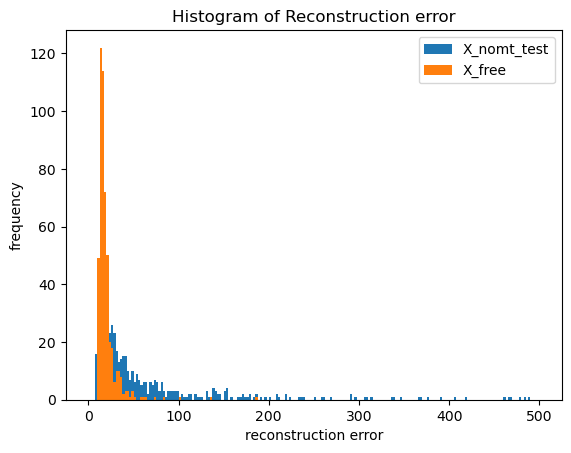

In [188]:
print_and_calc_results(autoencoder_small,X_nomt_test[:500],"X_nomt_test",X_free[:500],"X_free",scale=False)

Reconstruction Error of :
X_nomt_test
Mean
125.83797
Median
43.448288
Reconstruction Error of :
X_free
Mean
24.586403
Median
19.243282


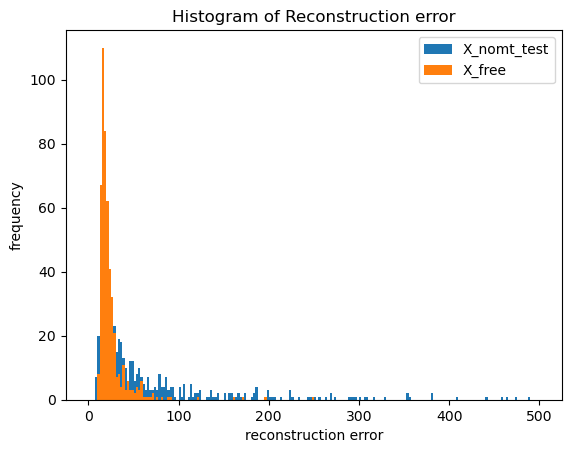

In [189]:
print_and_calc_results(autoencoder_medium,X_nomt_test[:500],"X_nomt_test",X_free[:500],"X_free",scale=False)

Reconstruction Error of :
X_nomt_test
Mean
174.92694
Median
48.188297
Reconstruction Error of :
X_free
Mean
30.278997
Median
22.69931


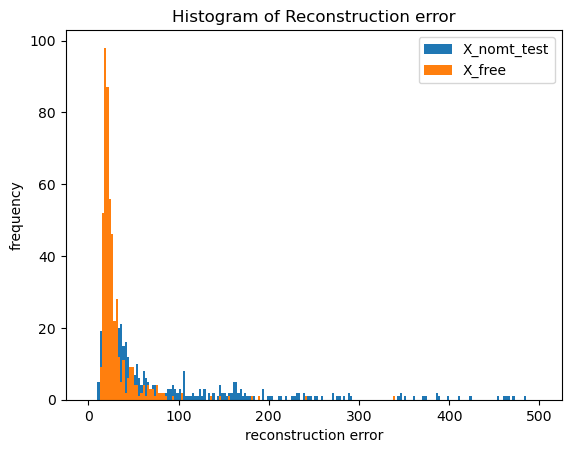

In [190]:
print_and_calc_results(autoencoder_large,X_nomt_test[:500],"X_nomt_test",X_free[:500],"X_free",scale=False)

Reconstruction Error of :
X_nomt_test
Mean
0.42486674
Median
0.17336366
Reconstruction Error of :
X_free
Mean
0.68259436
Median
0.60096836


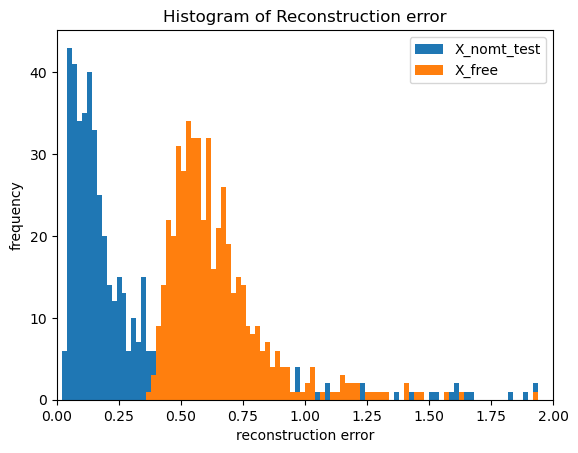

In [184]:
print_and_calc_results(autoencoder_small_scaled,scaled_X_nomt_test[:500],"X_nomt_test",scaled_X_free[:500],"X_free")

Reconstruction Error of :
X_nomt_test
Mean
0.5512001
Median
0.20311476
Reconstruction Error of :
X_free
Mean
0.8318454
Median
0.69081753


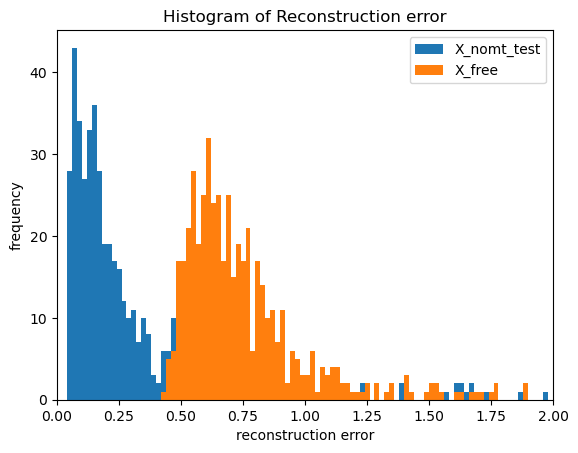

In [185]:
print_and_calc_results(autoencoder_medium_Scaled,scaled_X_nomt_test[:500],"X_nomt_test",scaled_X_free[:500],"X_free")

Reconstruction Error of :
X_nomt_test
Mean
0.6125158
Median
0.20422757
Reconstruction Error of :
X_free
Mean
0.84346235
Median
0.7008301


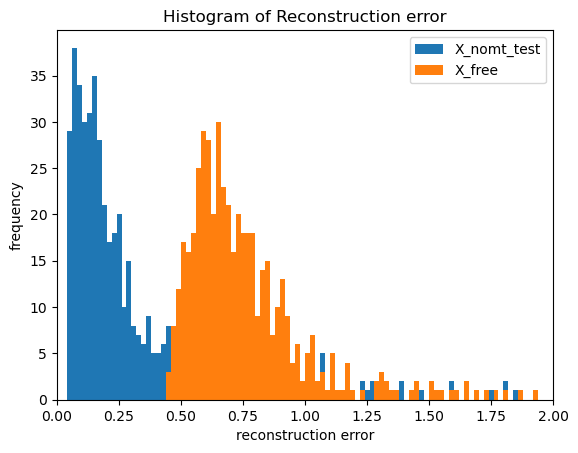

In [186]:
print_and_calc_results(autoencoder_large_Scaled,scaled_X_nomt_test[:500],"X_nomt_test",scaled_X_free[:500],"X_free")

Based on these histogramm we specify threshholds for classification :

* small --> 0.4
* medium --> 0.42
* large --> 0.42

In [148]:
def acc_over_n_runs(ae,A,B,th,n):
    A=A.numpy()
    B=B.numpy()
    erg=[]
    for i in np.arange(n):
        np.take(A,np.random.permutation(A.shape[0]),axis=0,out=A);
        np.take(B,np.random.permutation(B.shape[0]),axis=0,out=B);
        acc,_=calc_accuracy(ae,A[:500],B[:500],th)
        erg.append(acc)
    print(erg)
    print(f"Final acc over {n} runs:",np.mean(erg))


## Small

average of 10 runs 

In [149]:
acc_over_n_runs(autoencoder_small_scaled,scaled_X_nomt_test,scaled_X_free,0.4,10)

[0.86, 0.868, 0.893, 0.871, 0.866, 0.884, 0.869, 0.865, 0.868, 0.874]
Final acc over 10 runs: 0.8718


one run

In [119]:
acc_small,_=calc_accuracy(autoencoder_small_scaled,scaled_X_nomt_test[:500],scaled_X_free[:500],0.4)

In [120]:
acc_small

0.877

## Medium

average of 10 runs 

In [150]:
acc_over_n_runs(autoencoder_medium_Scaled,scaled_X_nomt_test,scaled_X_free,0.42,10)

[0.855, 0.861, 0.85, 0.856, 0.859, 0.861, 0.849, 0.841, 0.854, 0.841]
Final acc over 10 runs: 0.8526999999999999


one run

In [129]:
acc_medium,_=calc_accuracy(autoencoder_medium_Scaled,scaled_X_nomt_test[:500],scaled_X_free[:500],0.42)

In [130]:
acc_medium

0.863

## Large

average of 10 runs 

In [151]:
acc_over_n_runs(autoencoder_large_Scaled,scaled_X_nomt_test,scaled_X_free,0.42,10)

[0.848, 0.86, 0.857, 0.85, 0.864, 0.862, 0.851, 0.85, 0.842, 0.879]
Final acc over 10 runs: 0.8563000000000001


one run

In [131]:
acc_large,_=calc_accuracy(autoencoder_large_Scaled,scaled_X_nomt_test[:500],scaled_X_free[:500],0.42)

In [132]:
acc_large

0.866